# Laboratory Reinforcement Learning - Intelligent Systems

Students:
- Quiñones Rudon Diego Alejandro
- Melendez Angulo Venecia Carolina

## Introduction

In this project, the Q-learning algorithm was implemented to learn more about *Reinforcement Learning*. A game is played that consists of reaching a goal from a starting point on a map that is represented in a 7x9 grid, where it has the difficulty of going through winds that make it leave the map and lose the game.
In our case, the participant will be an agent who will be trained through rewards and penalties that tell the agent what he should do but not how to do it, applying the Bellman algorithm to his policy.

## Problem resolution planning

To implement the proposed game, we will first analyze what type of reward and penalties the agent will receive according to the states it may have. Tests of which would be the best values will be carried out in order to obtain an optimal policy that allows the agent to make better decisions.



First, the necessary code will be implemented to later carry out tests and analyze its behavior.

In [1]:
import numpy as np
import gym
import random
from termcolor import colored, cprint
import time
import math
from IPython.display import clear_output
from matplotlib import pyplot as plot
from PIL import Image

In [2]:
# 0 = empty_space; 1 = StartPosition_player; 2 = goal 
def draw_map(size, player_position, goal_position):
    map = np.zeros((size[1], size[0]), dtype=np.int)
    map[player_position[1], player_position[0]] = 1
    map[goal_position[1], goal_position[0]] = 2
    
    return map

In [39]:
class GameEnviroment:
    def __init__(self, map, size, player_initial_state, goal_position):
        self.map = map
        self.size = size
        self.player_state = player_initial_state
        self.goal = goal_position 
        
        # default
        self.rewards = {
            "walk": -1,
            "fall": -5,
            "goal": 100
        }
        
    def setSpecificRewards(self,forWalk , forFall, forGoal ):
        self.rewards = {
            "walk": forWalk,
            "fall": forFall,
            "goal": forGoal
        }

    def __str__(self):
        return str(self.map) + f"\nPlayerPos: ({self.player_state[0]}, {self.player_state[1]})"
    
    def reset(self, initial_map, player_initial_state):
        self.map = initial_map
        self.player_state = player_initial_state
        return ((10 * self.player_state[0]) + self.player_state[1])

    def is_in_goal(self):
        return (self.player_state[0] == self.goal[0] and self.player_state[1] == self.goal[1])
    
    def has_fallen_of_map(self):
        x_range = np.array(range(self.size[0]))
        y_range = np.array(range(self.size[1]))
        return (self.player_state[1] not in y_range or self.player_state[0] not in x_range)

    def move_player_left(self):
        self.player_state[0] = self.player_state[0] - 1
        if self.is_in_goal():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["goal"], True
        if self.has_fallen_of_map():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["fall"], True
        self.map = draw_map(self.size, self.player_state, self.goal)
        return (10*self.player_state[0] + self.player_state[1]), self.rewards["walk"], False
    
    def move_player_right(self):
        self.player_state[0] = self.player_state[0] + 1
        if self.is_in_goal():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["goal"], True
        if self.has_fallen_of_map():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["fall"], True
        self.map = draw_map(self.size, self.player_state, self.goal)
        return (10*self.player_state[0] + self.player_state[1]), self.rewards["walk"], False

    def move_player_up(self):
        self.player_state[1] = self.player_state[1] - 1
        if self.is_in_goal():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["goal"], True
        if self.has_fallen_of_map():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["fall"], True
        self.map = draw_map(self.size, self.player_state, self.goal)
        return (10*self.player_state[0] + self.player_state[1]), self.rewards["walk"], False
    
    def move_player_down(self):
        self.player_state[1] = self.player_state[1] + 1
        if self.is_in_goal():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["goal"], True
        if self.has_fallen_of_map():
            return (10*self.player_state[0] + self.player_state[1]), self.rewards["fall"], True
        self.map = draw_map(self.size, self.player_state, self.goal)
        return (10*self.player_state[0] + self.player_state[1]), self.rewards["walk"], False
        
    # 0 = LEFT, 1 = RIGHT, 2 = UP, 3 = DOWN
    def step(self, action , withWind = True ):
        if action == 0:
            new_state, reward, done = self.move_player_left()
        if action == 1:
            new_state, reward, done = self.move_player_right()
        if action == 2:
            new_state, reward, done = self.move_player_up()
        if action == 3:
            new_state, reward, done = self.move_player_down()
            
        if (withWind):
            # applying wind
            PrA = 0.1
            PrB = 0.2
            PrC = 0.15
            if self.player_state[0] == 3:
                random_number = np.random.uniform(low=0.0, high=1.0)
                if random_number <= PrA:
                    new_state, reward, done = self.move_player_up()

            if self.player_state[0] == 4:
                random_number = np.random.uniform(low=0.0, high=1.0)
                if random_number <= PrB:
                    new_state, reward, done = self.move_player_up()
                    new_state, reward, done = self.move_player_up()

            if self.player_state[0] == 5:
                random_number = np.random.uniform(low=0.0, high=1.0)
                if random_number <= PrC:
                    new_state, reward, done = self.move_player_up()
        
        return new_state, reward, done
    

In [40]:
def train_Qtable(envGame , withWind = True):
    for it in range(100):
        print('average ', it )
        rewards_all_episodes=[]

        # exporation-exploitation trade-off params
        exploration_rate = 1
        max_exploration_rate = 1
        min_exploration_rate = 0.01
        exploration_decay_rate = 0.005

        # init q table in zeros
        q_table = np.zeros((state_space_size, action_space_size))

        # iterate over the episodes
        for episode in range(num_episodes):
            player_initial_pos = [1, 1]
            initial_map = draw_map(map_size, player_initial_pos, goal_pos)
            state = envGame.reset(initial_map, player_initial_pos)
            done = False
            rewards_current_episode = 0

            # iterate over the steps for an episode
            for step in range(max_steps_per_episode):
                # Exploration-exploitation trade-off
                exploration_rate_threshold = np.random.uniform(low=0.0, high=1.0)
                if exploration_rate_threshold <= exploration_rate:
                    # Expl oration time
                    action = np.random.randint(0, action_space_size)
                else:
                    # Explotation time
                    action = np.argmax(q_table[state])

                # Take action
                new_state, reward, done = envGame.step(action,withWind)

                # Update Q-table for Q(s,a)
                q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount_rate * np.max(q_table[new_state]))
                # transition next state

                state = new_state
                rewards_current_episode += reward

                if done == True: 
                    break


            # Exploration rate decay
            exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) * (math.e ** (-exploration_decay_rate * episode))

            rewards_all_episodes.append(rewards_current_episode)
        rewards_avg.append(rewards_all_episodes)
    return q_table

In [41]:
# To prepare environment of the game
map_size = [9, 7]
player_initial_pos = [1, 1]
goal_pos = [7, 4]

initial_map = draw_map(map_size, player_initial_pos, goal_pos)
envGame = GameEnviroment(initial_map, map_size, player_initial_pos, goal_pos)
print(envGame)

[[0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
PlayerPos: (1, 1)


C:\Users\INTER14\AppData\Local\Temp/ipykernel_8368/1331940733.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  map = np.zeros((size[1], size[0]), dtype=np.int)


In [7]:
#  To graph policy of the q_table
# 0 = LEFT, 1 = RIGHT, 2 = UP, 3 = DOWN
def get_optimal_action(map_coord,q_table):
    state = 10 * map_coord[0] + map_coord[1]
    optimal_action = np.argmax(q_table[state])
    return optimal_action


downArrow_img = Image.open('downArrow.JPG')
upArrow_img = Image.open('upArrow_2.JPG')
leftArrow_img = Image.open('leftArrow.JPG')
rightArrow_img = Image.open('rightArrow.JPG')

goalPosition_img = Image.open('goal.JPG')
startPosition_img = Image.open('start.JPG')
# 0 = LEFT, 1 = RIGHT, 2 = UP, 3 = DOWN
list_images = [leftArrow_img,rightArrow_img, upArrow_img,downArrow_img]


#player_initial_pos = [1, 1]
#goal_pos = [7, 4]

isInitialPos = lambda pos : pos[0] == player_initial_pos[0] and pos[1] == player_initial_pos[1]
isGoalPos    = lambda pos : pos[0] == goal_pos[0]           and pos[1] == goal_pos[1]

def get_imageOfPolicy(q_table):
    # dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    imageOfPolicy = Image.new('RGB', (9 * downArrow_img.width ,7* downArrow_img.height))

    sumHeight = 0
    for rows in range(map_size[1]):
        sumWidth = 0
        for elem in range(map_size[0]):
            if (isInitialPos([elem,rows])):
                imageOfPolicy.paste(startPosition_img, (sumWidth,sumHeight))
            elif (isGoalPos([elem,rows])):
                imageOfPolicy.paste(goalPosition_img, (sumWidth,sumHeight))
            else:
                optimal_action = get_optimal_action((elem, rows),q_table)
                arrowImg = list_images[optimal_action]
                imageOfPolicy.paste(arrowImg, (sumWidth,sumHeight))
            
            sumWidth = sumWidth + arrowImg.width
        sumHeight = sumHeight + arrowImg.height
    return imageOfPolicy

Inicializando parametros 

In [8]:
# Inicialize parameters
num_episodes = 15000
#num_episodes = 150
max_steps_per_episode = 200

learning_rate = 0.1
discount_rate = 0.95

action_space_size = 4
# table is 7x9
state_space_size = 100

## Answering questions

> Question 1: How do you plan to penalize and reward the agent?

First, we thought about the values that the agent would obtain when performing a step. It was decided to use a negative unit (penalize), with the idea that otherwise, being positive, the agent could lose sight of the goal of reaching the goal and just want to move forward and travel more paths instead of concentrating on finding the goal. target directly.

On the other hand, the simple part, it was decided to penalize with negative units when the agent leaves the map (is outside the defined grid) and positive units when the agent reaches his goal.

To understand the effect that the units assigned in reward would have for reaching the goal and the penalty for leaving the map, tests were carried out with the following parameters:

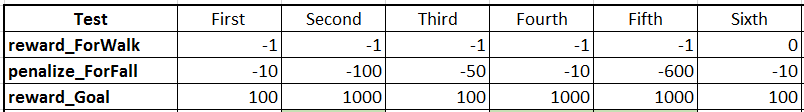

### First Test

In [10]:
rewards_avg = []

# Applying Q-learning
reward_ForWalk = -1
penalize_ForFall = -10
reward_Goal = 100
envGame.setSpecificRewards(reward_ForWalk , penalize_ForFall, reward_Goal)
q_table_1 = train_Qtable(envGame)

average  0


C:\Users\INTER14\AppData\Local\Temp/ipykernel_8368/1331940733.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  map = np.zeros((size[1], size[0]), dtype=np.int)


average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
average  84
a

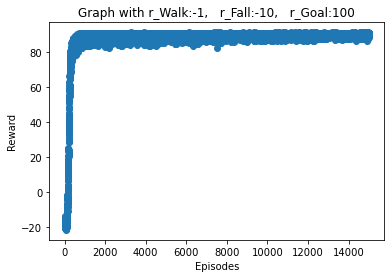

In [11]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.title(f"Graph with r_Walk:{reward_ForWalk},   r_Fall:{penalize_ForFall},   r_Goal:{reward_Goal}"  )
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

In [32]:
q_table_1

array([[-7.94108868e+00, -2.89620031e+00, -4.68559000e+00,
        -2.81465626e+00],
       [-8.64914828e+00,  5.15530342e+01, -2.93274235e+00,
        -2.88902718e+00],
       [-7.94108868e+00,  5.55671122e+01, -1.98058401e+00,
        -1.81925434e+00],
       [-7.71232075e+00,  5.79147621e+01, -1.20508257e+00,
        -1.98496226e+00],
       [-7.17570464e+00, -1.57914961e+00, -1.59912517e+00,
        -1.53079824e+00],
       [-6.12579511e+00, -1.18942205e+00, -1.20756026e+00,
        -1.20826334e+00],
       [-1.90000000e+00, -9.85058304e-01, -9.38829183e-01,
        -3.43900000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.97811895e+00, -2.94966333e+00, -8.33228183e+00,
         5.10302049e+01],
       [ 4.60663365e+01,  5.35908704e+01,  4.48097398e+01,
      

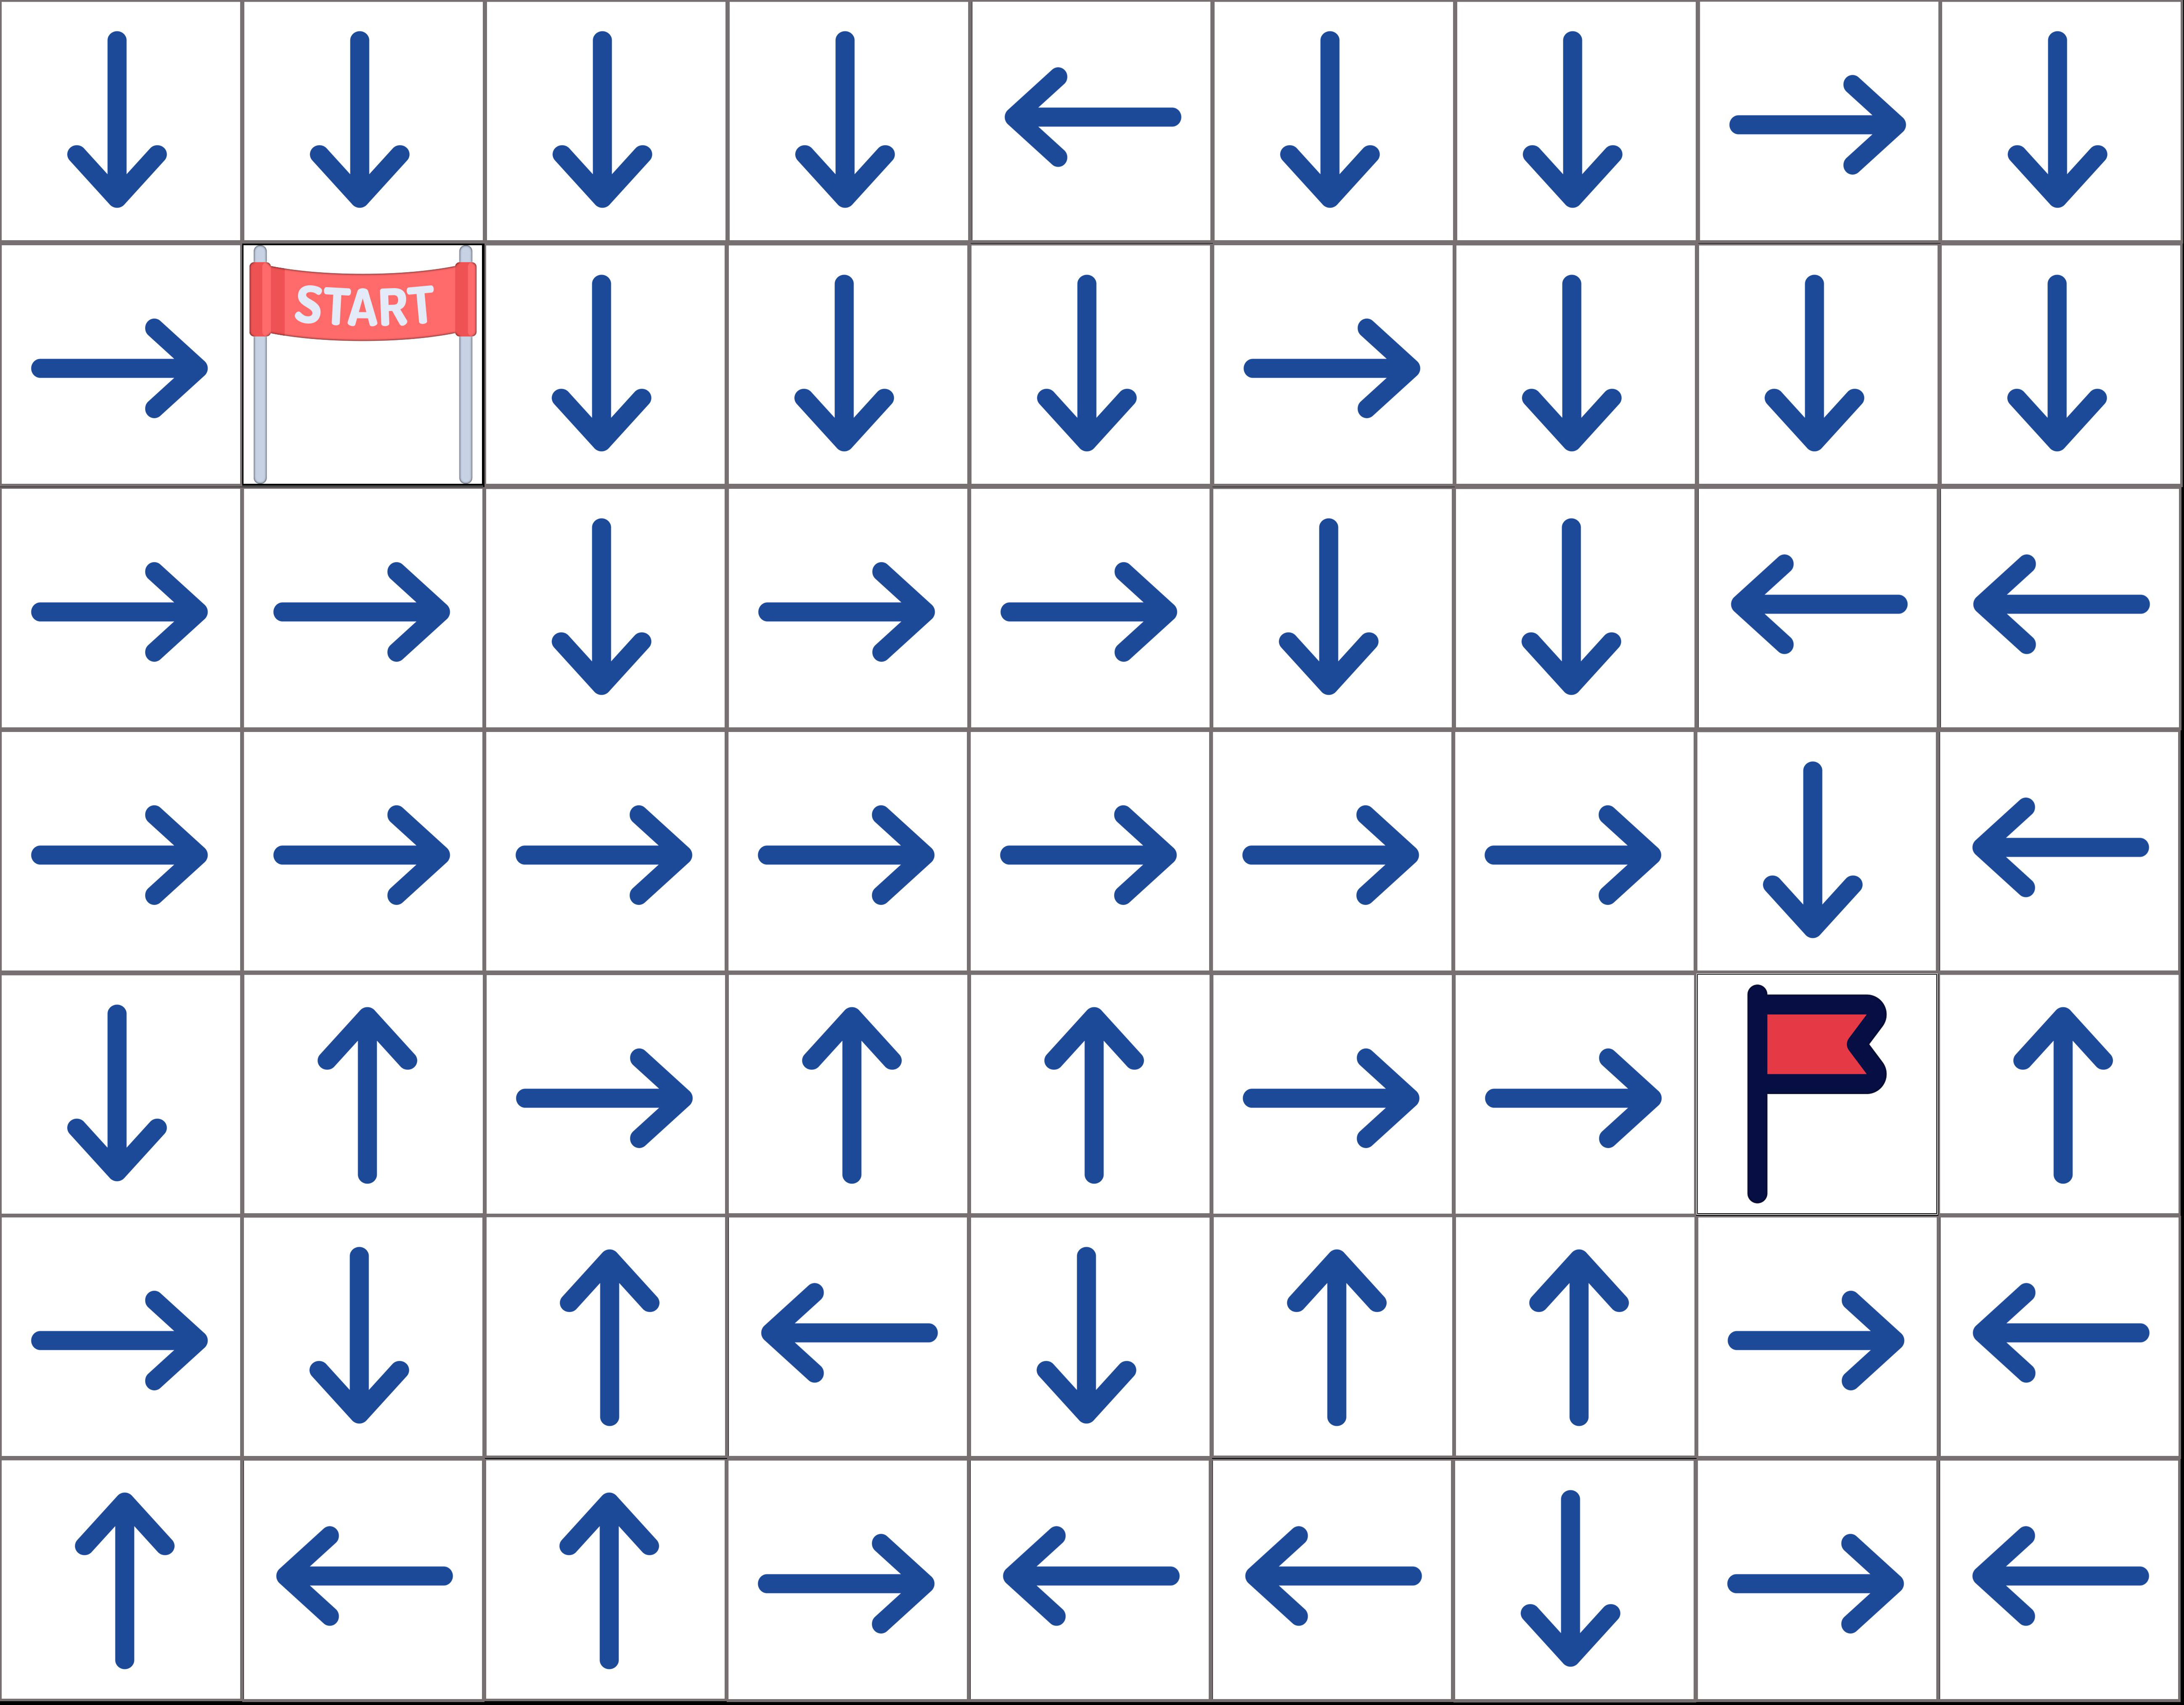

In [14]:
display(get_imageOfPolicy(q_table_1))

### Second Test

In [16]:
# Reset variables
rewards_avg = []

# Applying Q-learning
reward_ForWalk = -1
penalize_ForFall = -100
reward_Goal = 1000
envGame.setSpecificRewards(reward_ForWalk , penalize_ForFall, reward_Goal)
q_table_2 = train_Qtable(envGame)

average  0


C:\Users\INTER14\AppData\Local\Temp/ipykernel_8368/1331940733.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  map = np.zeros((size[1], size[0]), dtype=np.int)


average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
average  84
a

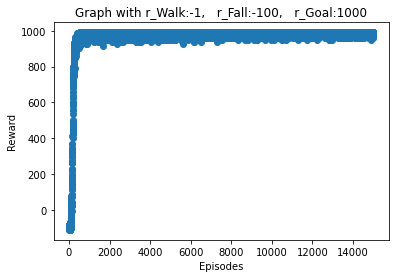

In [17]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.title(f"Graph with r_Walk:{reward_ForWalk},   r_Fall:{penalize_ForFall},   r_Goal:{reward_Goal}"  )
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

In [18]:
q_table_2

array([[-7.17570464e+01, -3.14032740e+00, -7.94108868e+01,
         5.30367315e+01],
       [-8.33228183e+01,  5.57219929e+02, -3.19061227e+00,
         1.13498827e+01],
       [-7.17570464e+01,  6.01045918e+02, -2.74041892e+00,
        -2.77796537e+00],
       [-8.14697981e+01,  2.31766468e+01, -2.31014862e+00,
        -2.26435703e+00],
       [-6.86189404e+01, -1.83026226e+00, -1.86413646e+00,
        -1.83456411e+00],
       [-6.51321560e+01, -1.42214763e+00, -1.41805244e+00,
        -1.45885211e+00],
       [-1.00000000e+01, -1.31207092e+00, -1.23018644e+00,
        -5.69532790e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.18612019e+00, -3.40569352e+00, -9.28210201e+01,
         5.60894522e+02],
       [ 4.82589869e+02,  5.58110962e+02,  4.92956133e+02,
      

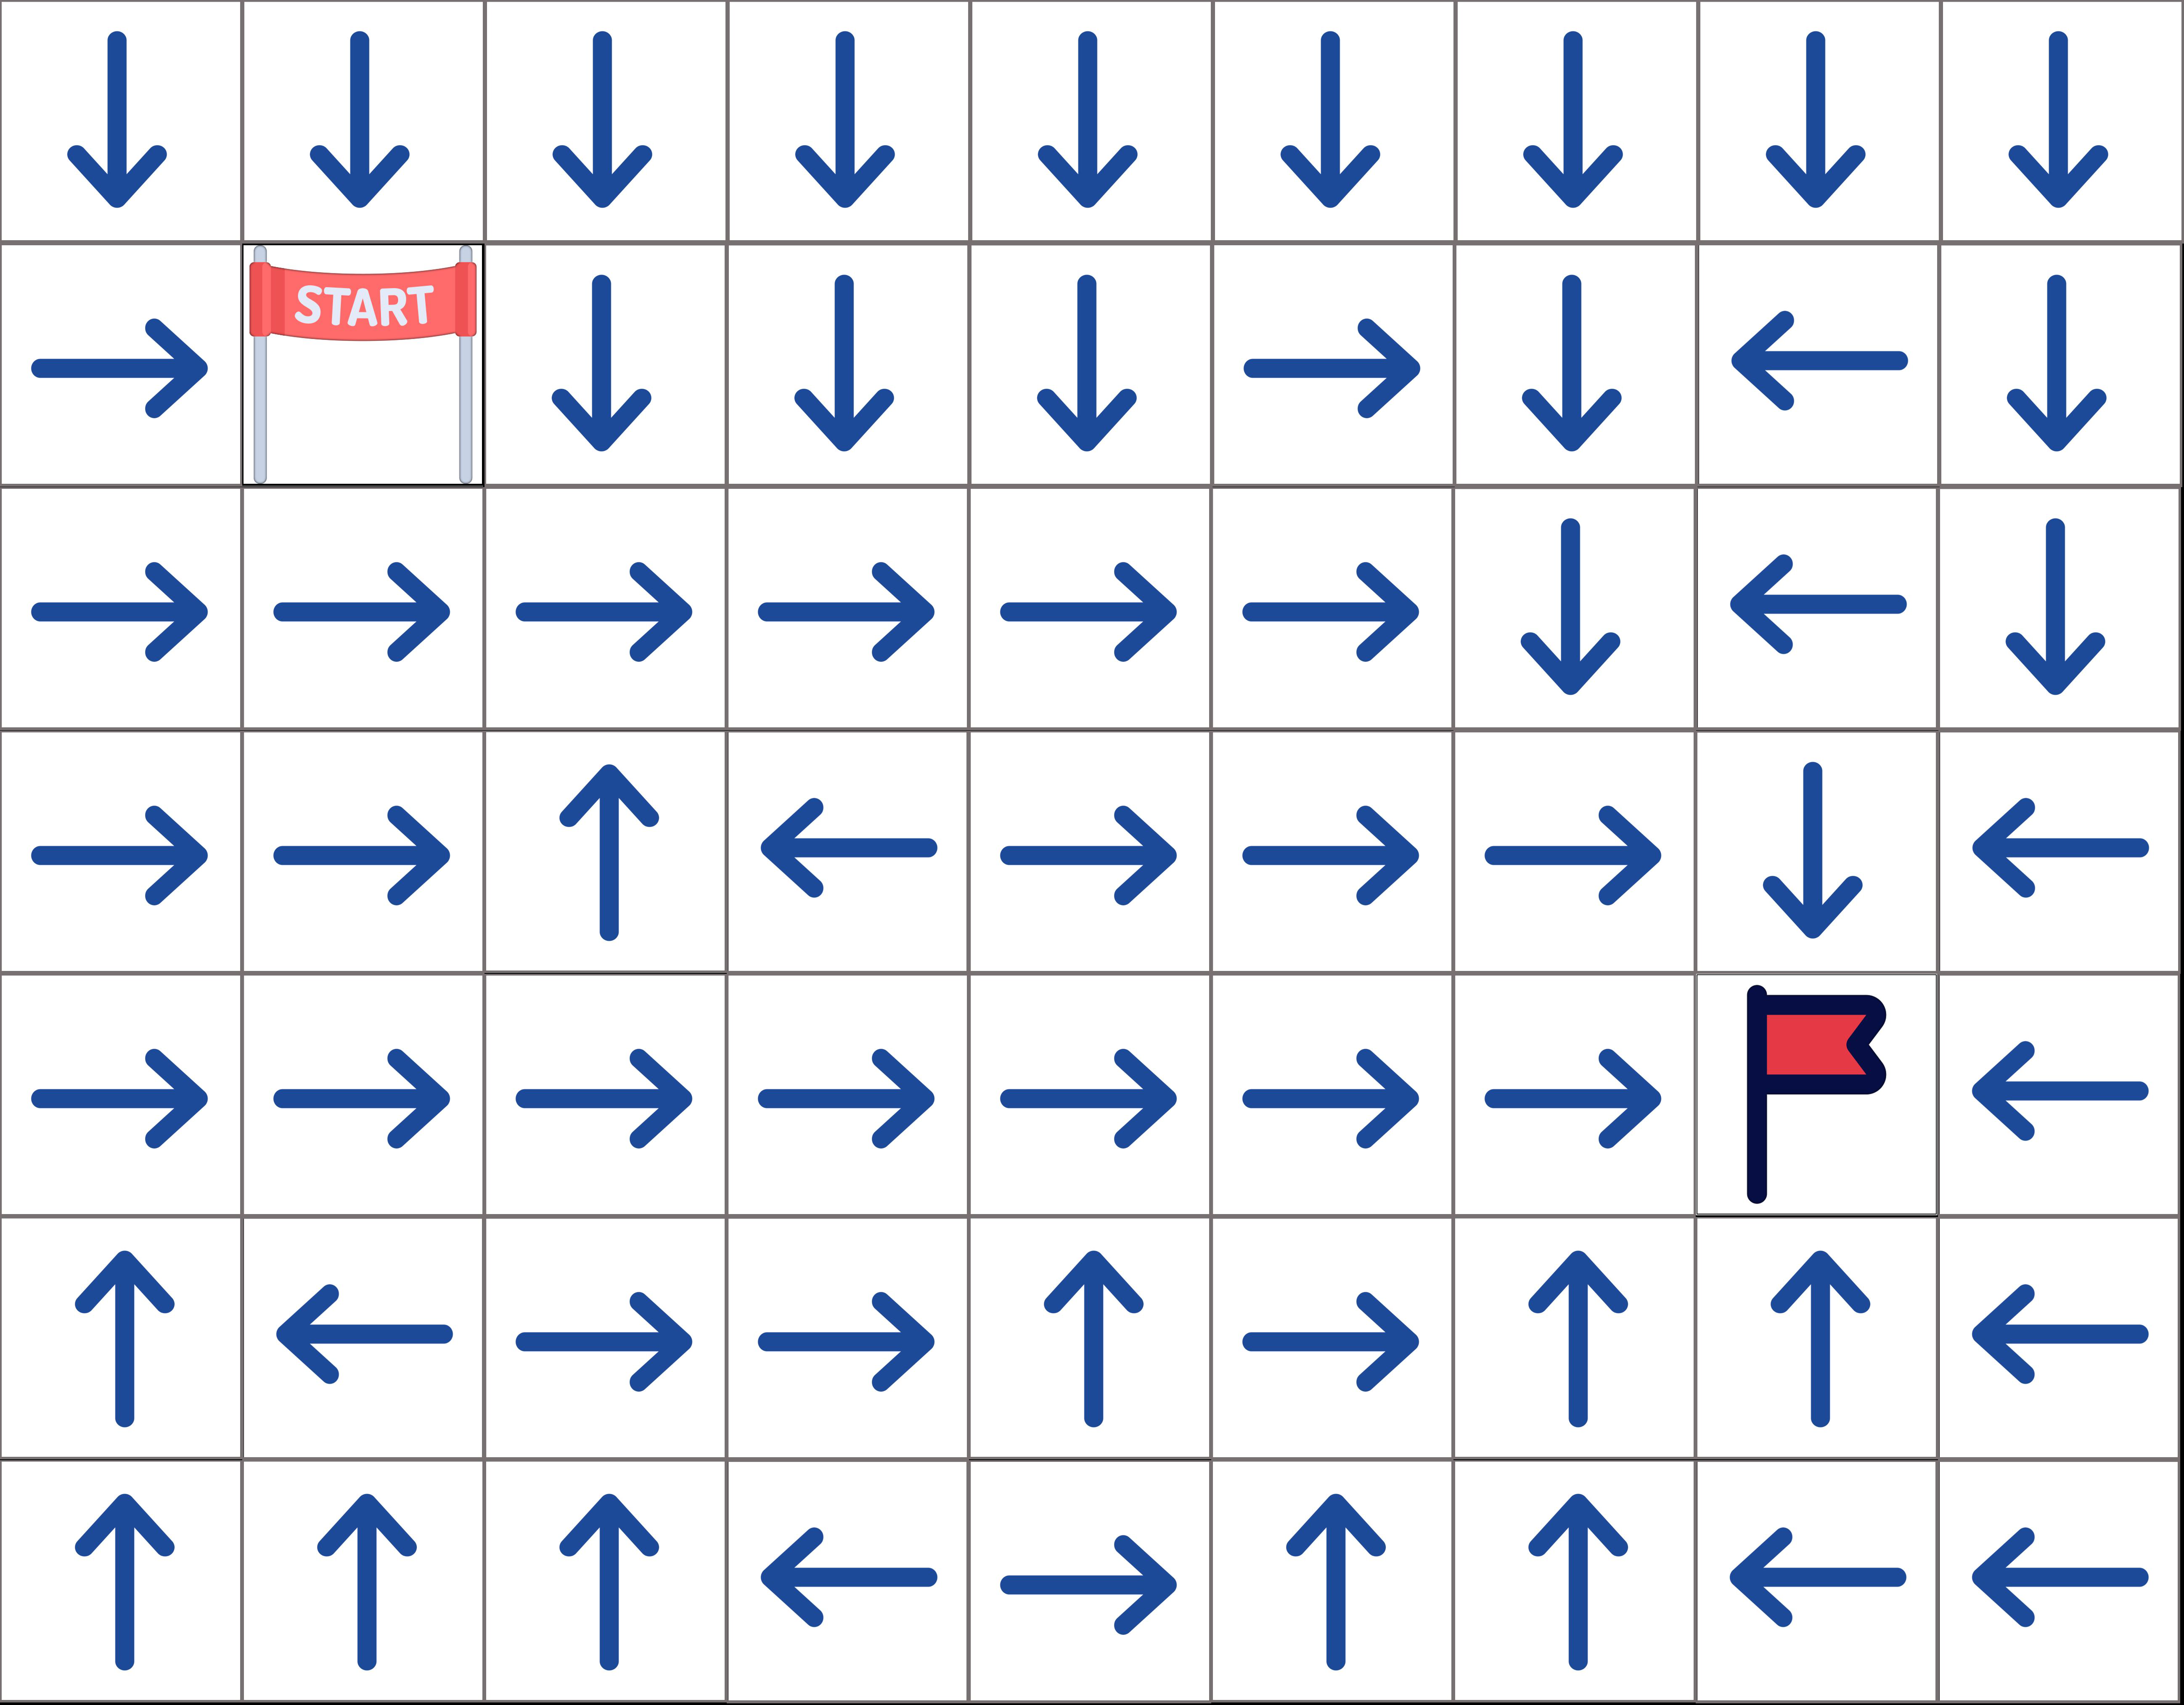

In [19]:
display(get_imageOfPolicy(q_table_2))

## Third Test  

In [20]:
# Reset variables
rewards_avg = []

# Applying Q-learning
reward_ForWalk = -1
penalize_ForFall = -50
reward_Goal = 100
envGame.setSpecificRewards(reward_ForWalk , penalize_ForFall, reward_Goal)
q_table_3 = train_Qtable(envGame)

average  0


C:\Users\INTER14\AppData\Local\Temp/ipykernel_8368/1331940733.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  map = np.zeros((size[1], size[0]), dtype=np.int)


average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
average  84
a

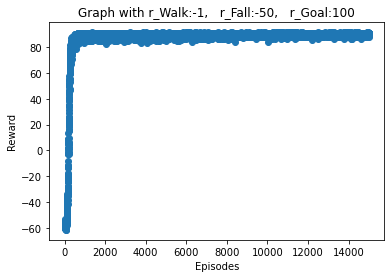

In [21]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.title(f"Graph with r_Walk:{reward_ForWalk},   r_Fall:{penalize_ForFall},   r_Goal:{reward_Goal}"  )
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

In [22]:
q_table_3

array([[-3.06289755e+01, -6.47679527e-01, -2.60851550e+01,
        -3.29491868e+00],
       [-4.84548423e+01,  5.15075264e+01, -3.44245768e+00,
        -3.28253428e+00],
       [-4.45290505e+01,  2.93310715e+00, -2.91357591e+00,
        -2.85462766e+00],
       [-2.84766395e+01, -2.14549825e+00, -2.51419252e+00,
        -2.37012801e+00],
       [-2.84766395e+01, -1.66030073e+00, -1.99894127e+00,
        -1.86064011e+00],
       [-2.04755000e+01, -1.50687497e+00, -1.45435976e+00,
        -1.47641105e+00],
       [-2.04755000e+01, -1.18281780e+00, -1.33853793e+00,
        -2.04755000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.36315234e+00, -3.29115623e+00, -4.73832618e+01,
         5.18312743e+01],
       [ 4.56049035e+01,  5.61359599e+01,  4.60716888e+01,
      

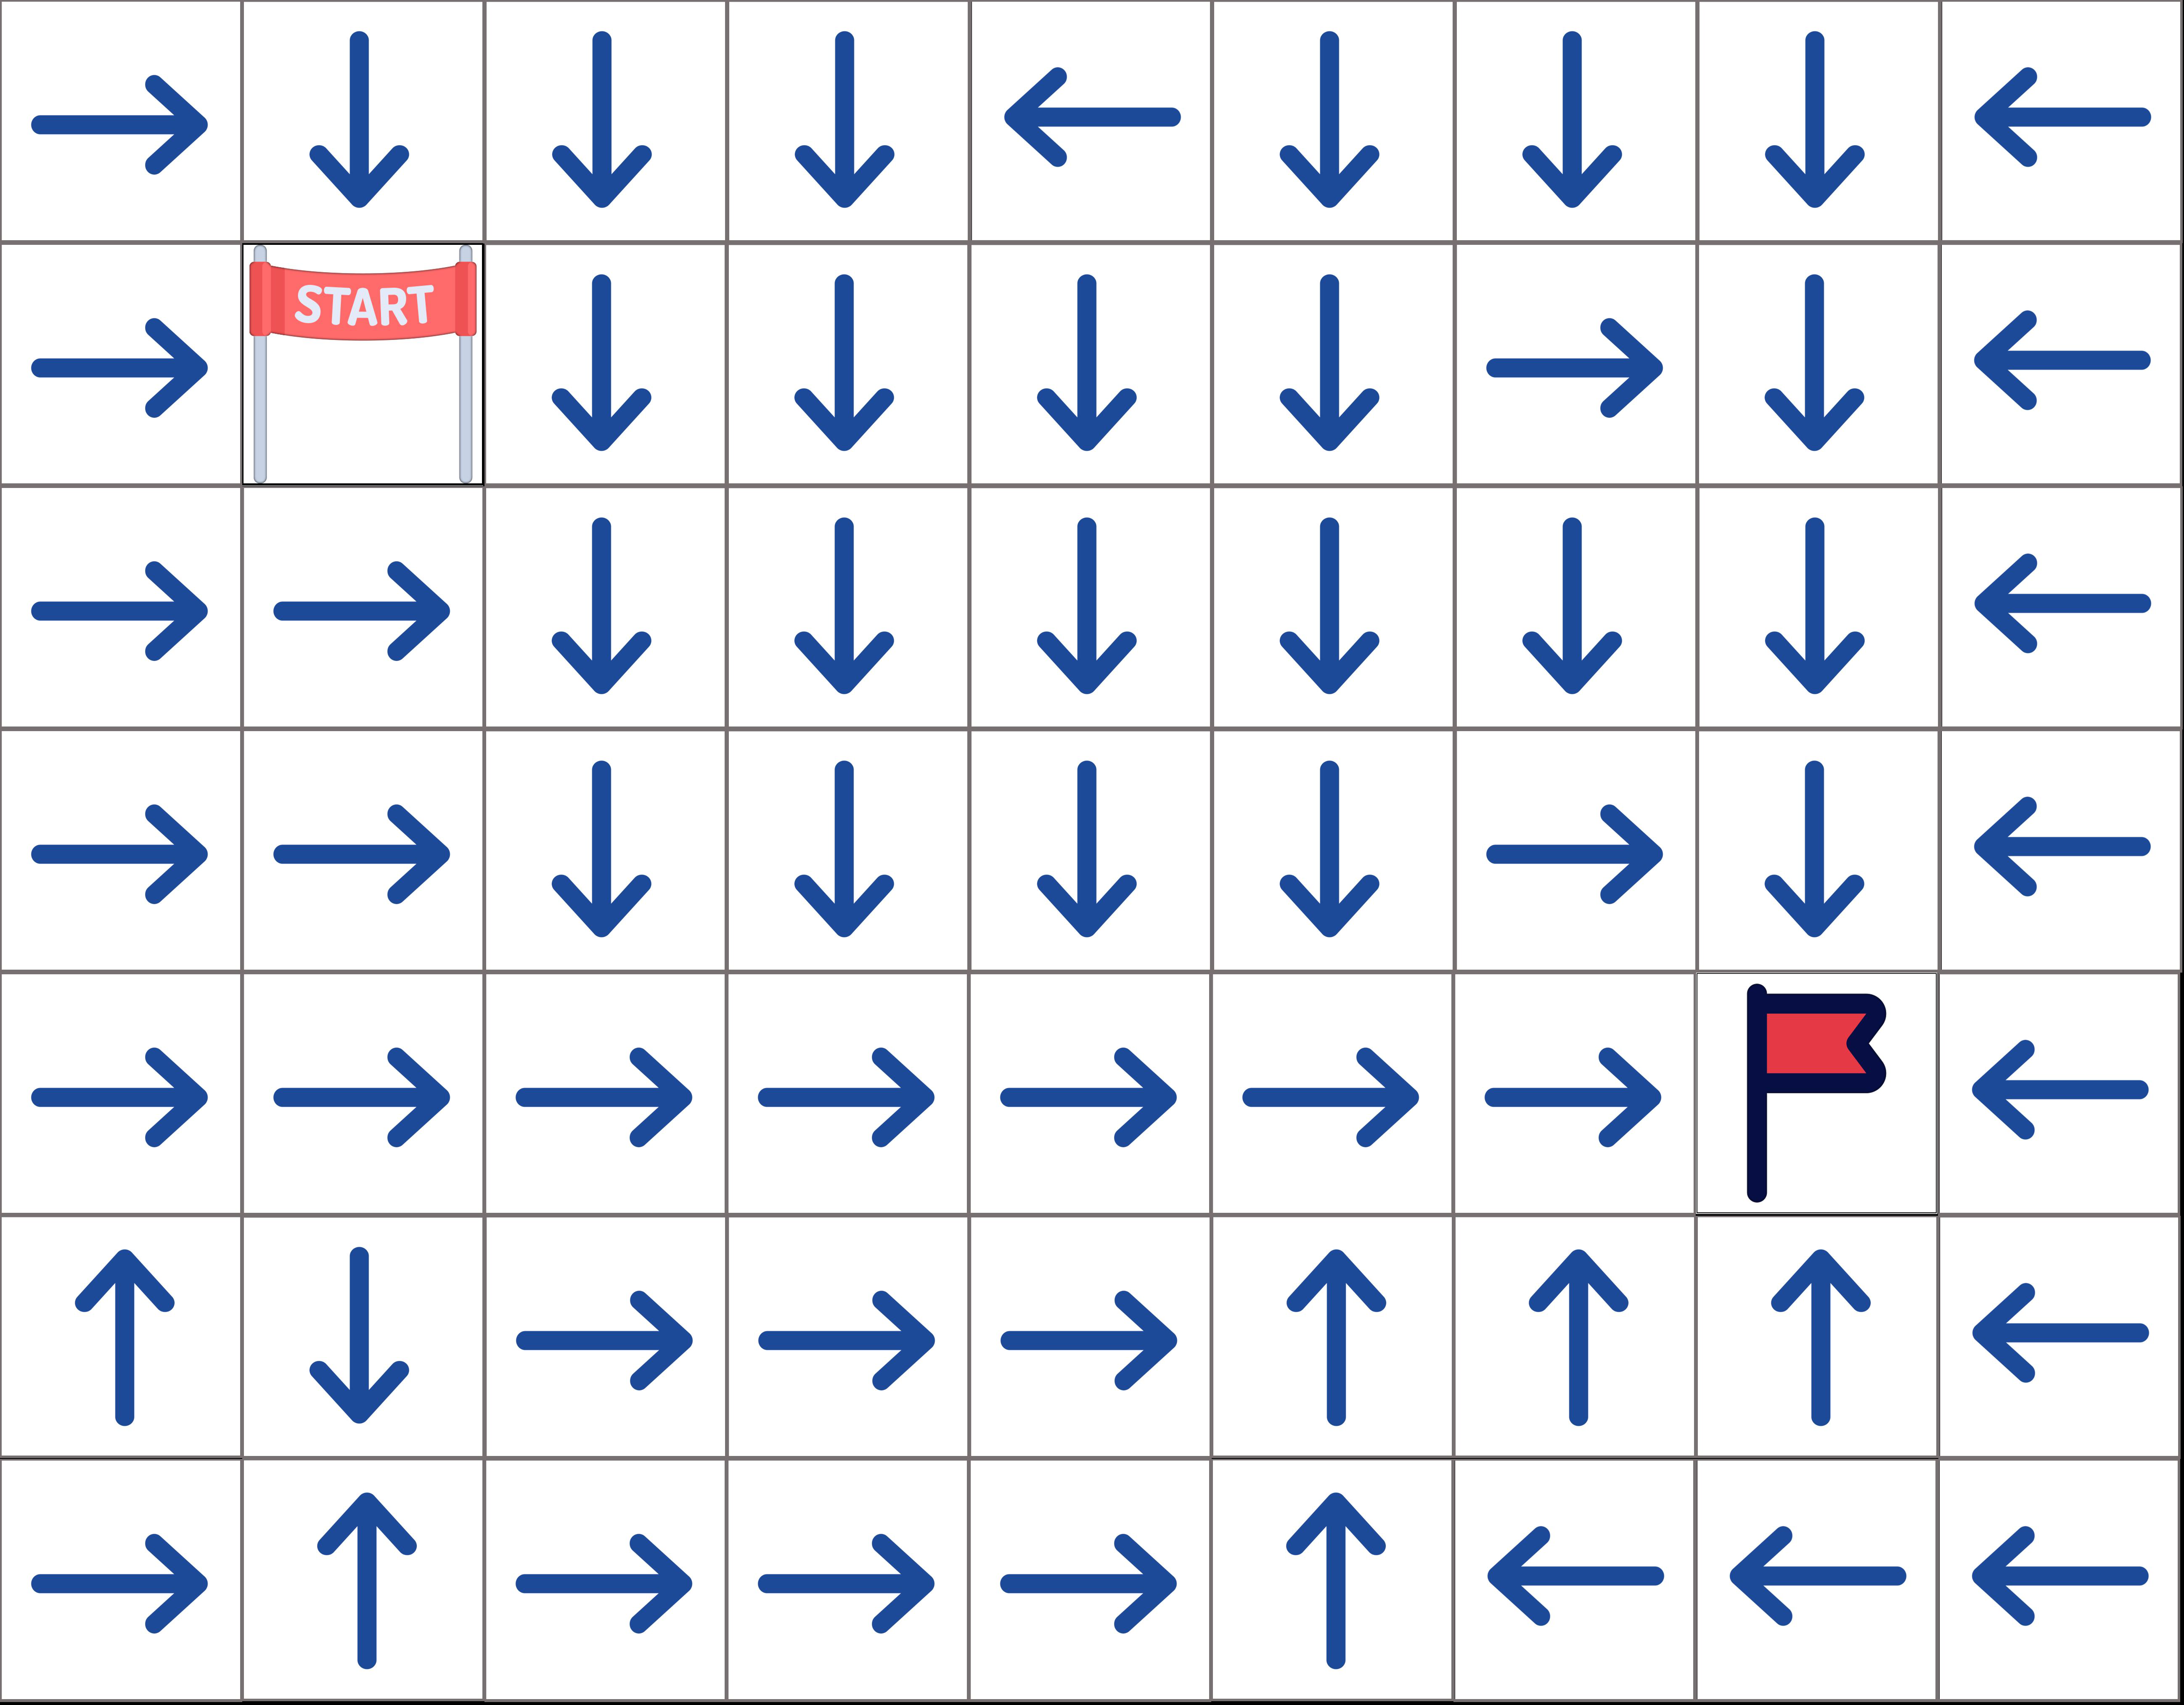

In [23]:
display(get_imageOfPolicy(q_table_3))

### Fourth Test

In [24]:
# Reset variables
rewards_avg = []

# Applying Q-learning
reward_ForWalk = -1
penalize_ForFall = -10
reward_Goal = 1000
envGame.setSpecificRewards(reward_ForWalk , penalize_ForFall, reward_Goal)
q_table_4 = train_Qtable(envGame)

average  0


C:\Users\INTER14\AppData\Local\Temp/ipykernel_8368/1331940733.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  map = np.zeros((size[1], size[0]), dtype=np.int)


average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
average  84
a

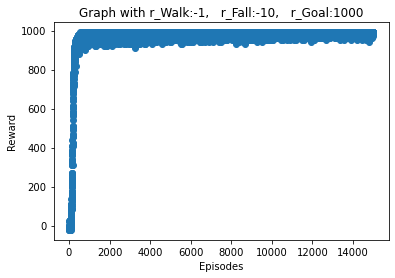

In [25]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.title(f"Graph with r_Walk:{reward_ForWalk},   r_Fall:{penalize_ForFall},   r_Goal:{reward_Goal}"  )
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

In [26]:
q_table_4

array([[-7.45813417e+00, -2.76806374e+00, -8.14697981e+00,
         5.31286314e+01],
       [-8.78423345e+00,  1.55653256e+02, -2.45062401e+00,
         5.92278886e+02],
       [-8.78423345e+00,  6.34406368e+02,  1.12371791e+01,
         4.94904205e+00],
       [-8.14697981e+00,  6.66628630e+02, -2.20217723e+00,
        -1.67007988e+00],
       [-6.51321560e+00,  7.00934319e+02,  4.40900621e+01,
        -1.27751358e+00],
       [-4.68559000e+00,  4.92124535e+01, -9.63223224e-01,
        -9.29273112e-01],
       [-2.71000000e+00, -6.88361504e-01, -7.28839998e-01,
        -2.71000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.07649244e+00, -3.09060408e+00, -8.78423345e+00,
         5.90451729e+02],
       [ 5.29866375e+02,  5.32088900e+02,  5.17979491e+02,
      

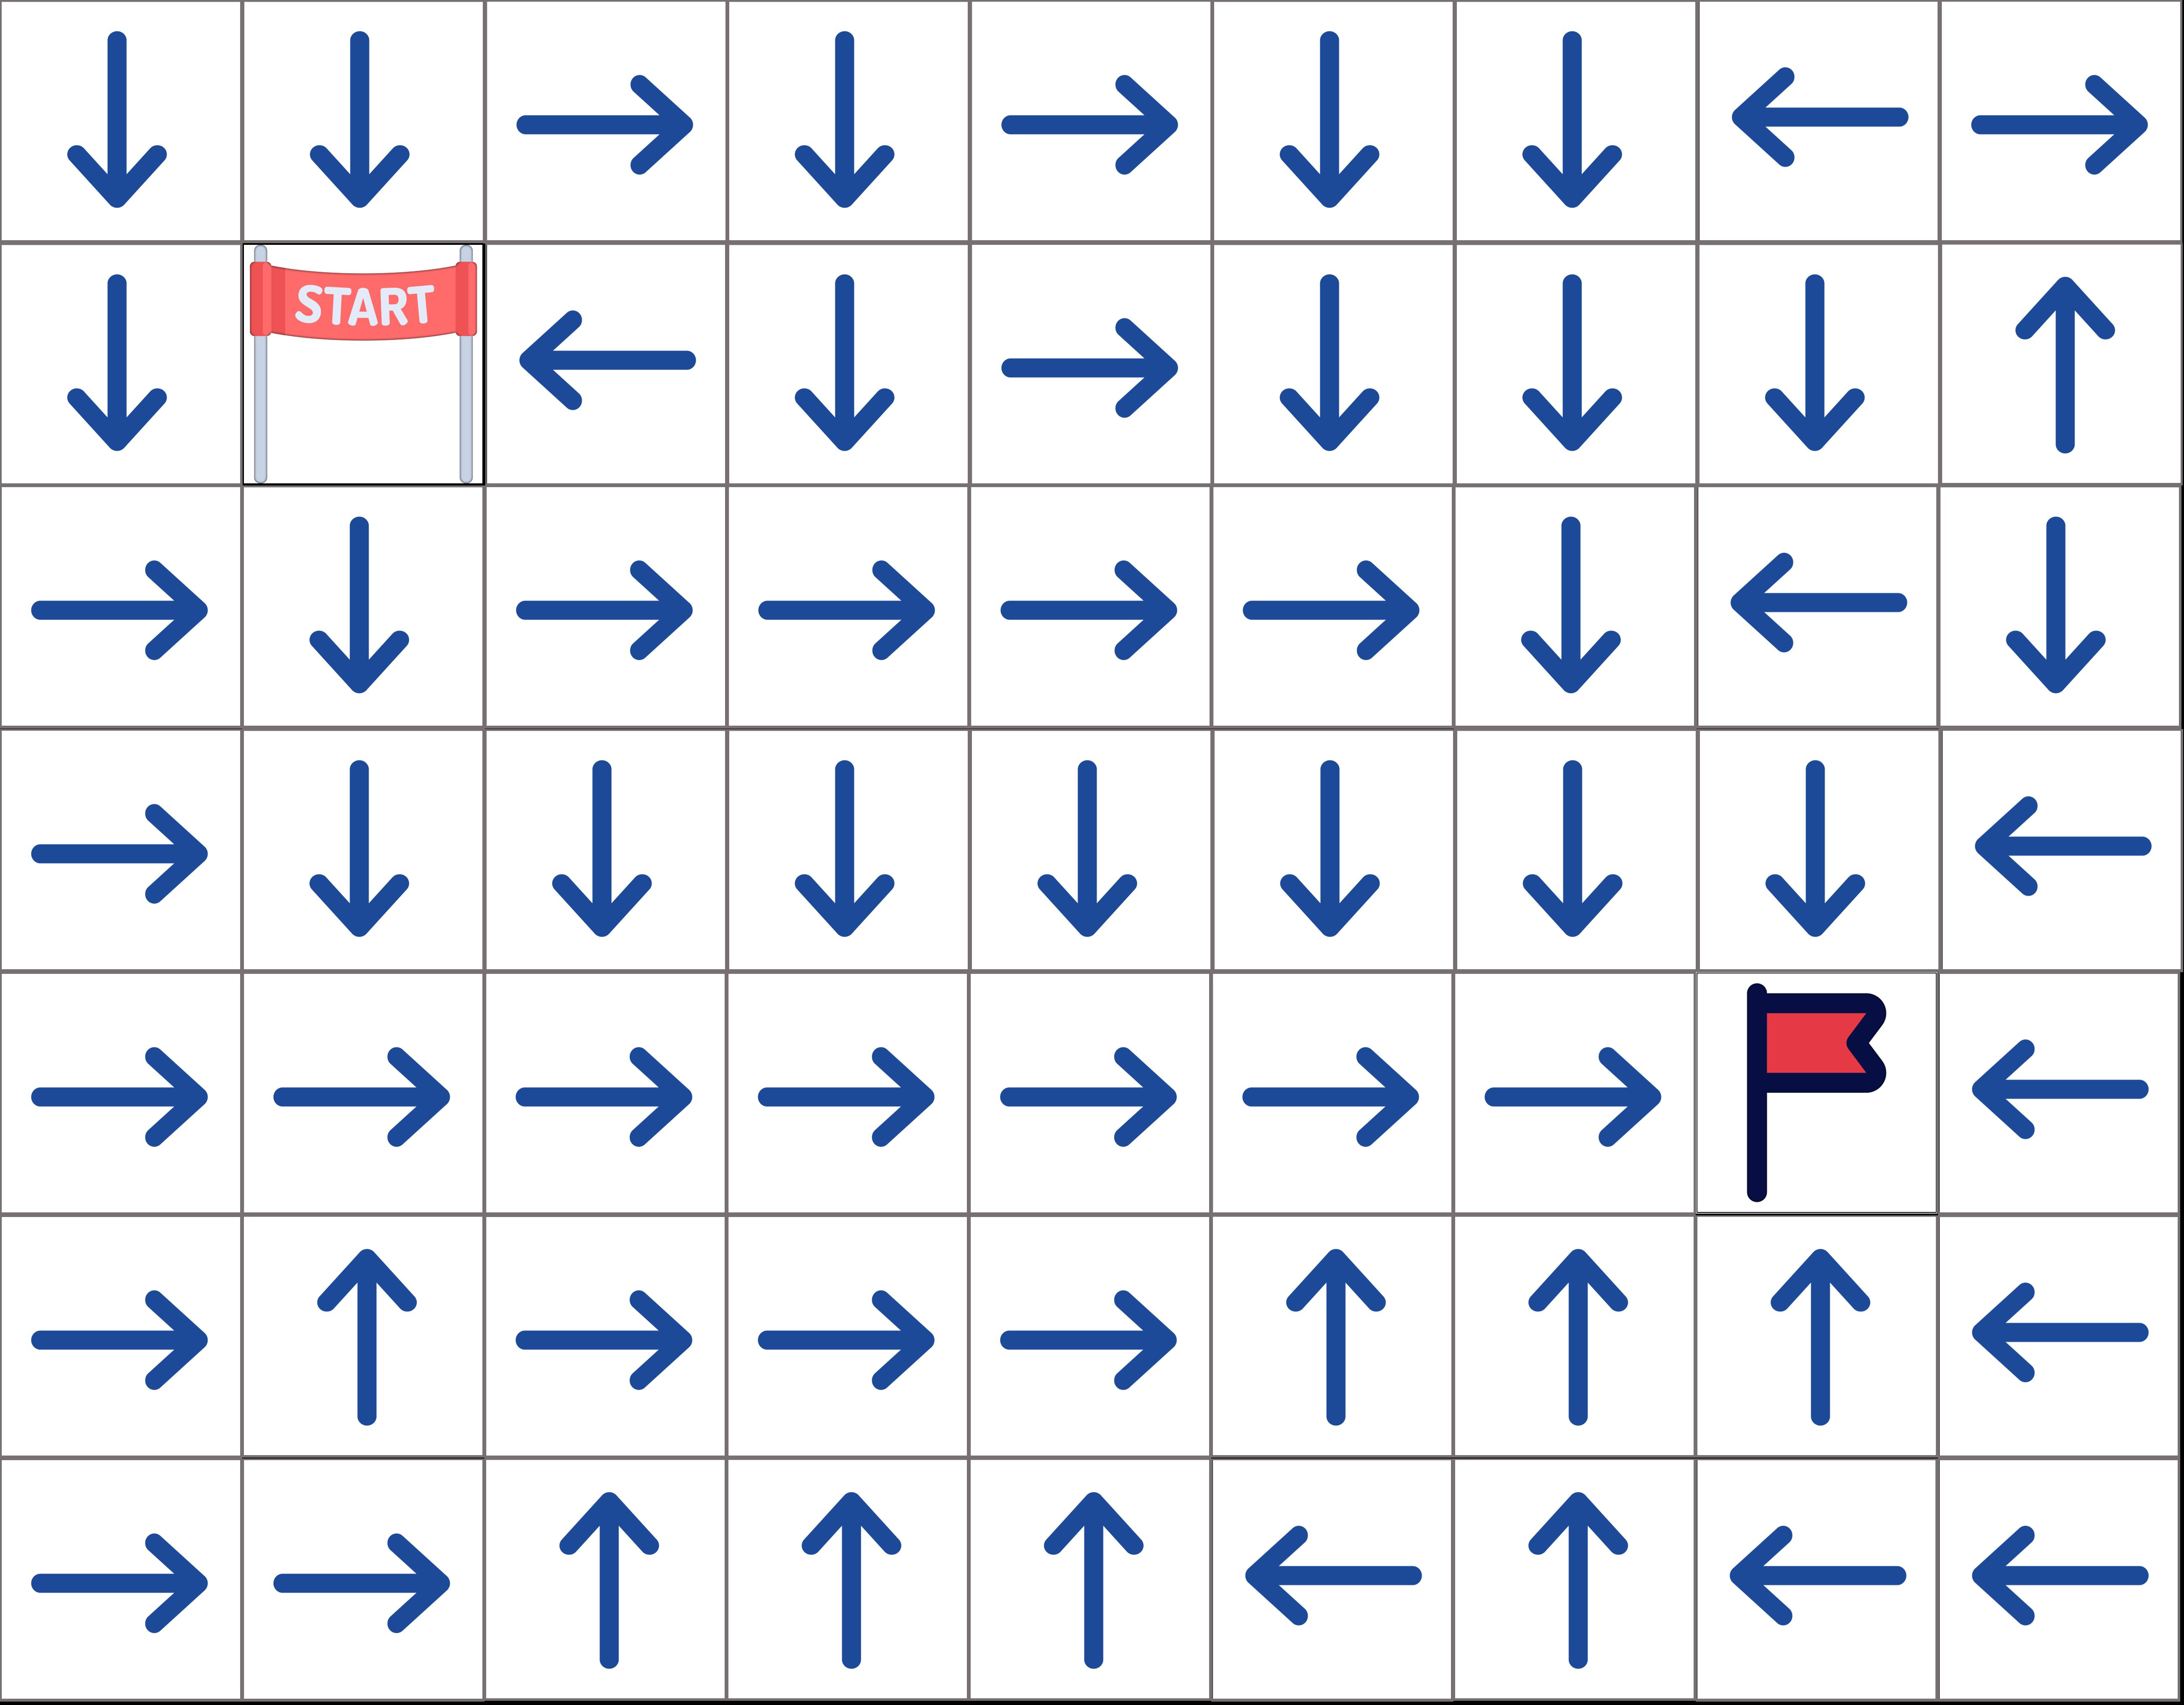

In [27]:
display(get_imageOfPolicy(q_table_4))

### Fifth Test

In [28]:
# Reset variables
rewards_avg = []

# Applying Q-learning
reward_ForWalk = -1
penalize_ForFall = -600
reward_Goal = 1000
envGame.setSpecificRewards(reward_ForWalk , penalize_ForFall, reward_Goal)
q_table_5 = train_Qtable(envGame)

average  0


C:\Users\INTER14\AppData\Local\Temp/ipykernel_8368/1331940733.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  map = np.zeros((size[1], size[0]), dtype=np.int)


average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
average  84
a

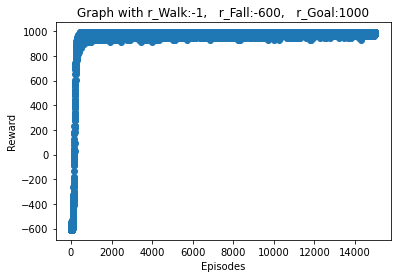

In [29]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.title(f"Graph with r_Walk:{reward_ForWalk},   r_Fall:{penalize_ForFall},   r_Goal:{reward_Goal}"  )
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

In [30]:
q_table_5

array([[-4.76465321e+02, -2.75928265e+00, -3.67547707e+02,
         5.61282602e+01],
       [-5.68599142e+02,  5.89183184e+02, -2.83657932e+00,
        -2.71079693e+00],
       [-4.47488050e+02,  6.17404961e+02,  1.13817035e+01,
        -1.65609767e+00],
       [-4.11713642e+02,  3.14948114e+01, -1.92880093e+00,
        -1.81447736e+00],
       [-4.30542278e+02, -1.44238141e+00, -3.66176921e-01,
        -1.36253631e+00],
       [-2.81135400e+02, -9.33859796e-01, -1.33410267e+00,
        -8.04888248e-01],
       [-2.45706000e+02, -7.19382493e-01, -6.13424922e-01,
        -6.00000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.92983427e+00, -2.84313252e+00, -5.68599142e+02,
         5.88801109e+02],
       [ 5.40669338e+02,  6.08856666e+02,  5.41880472e+02,
      

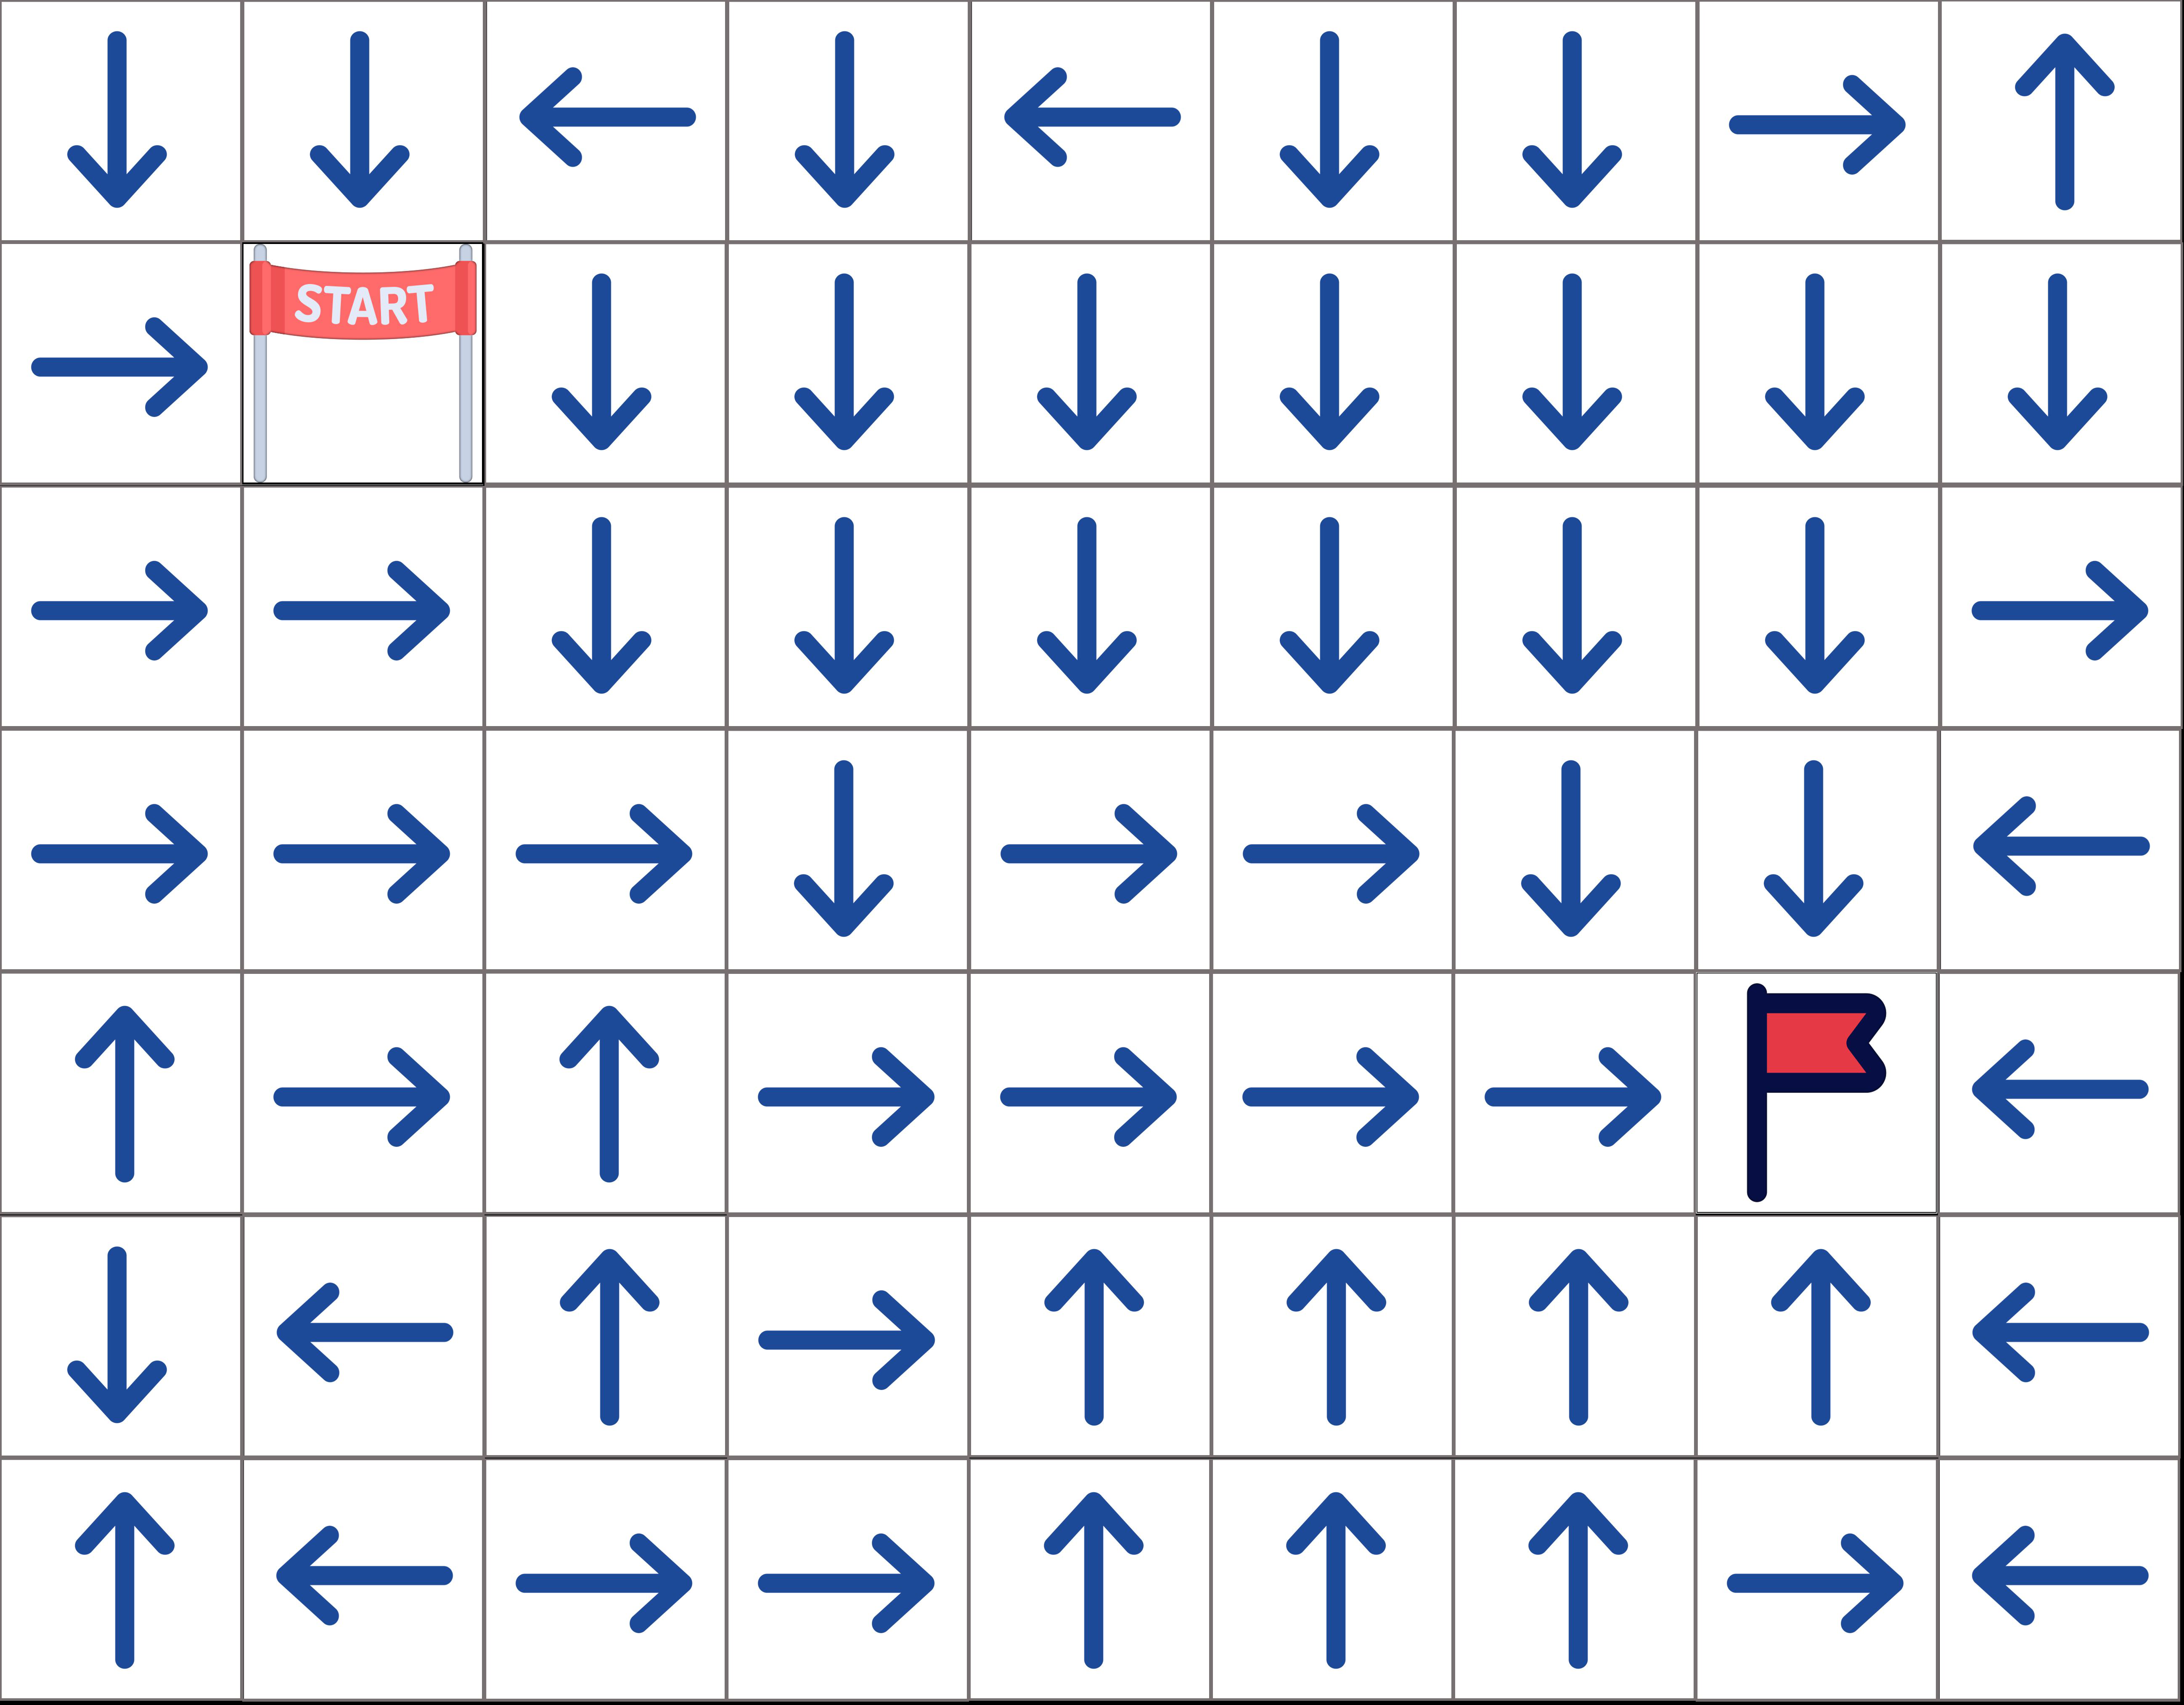

In [31]:
display(get_imageOfPolicy(q_table_5))

#### Comparison and analysis of results

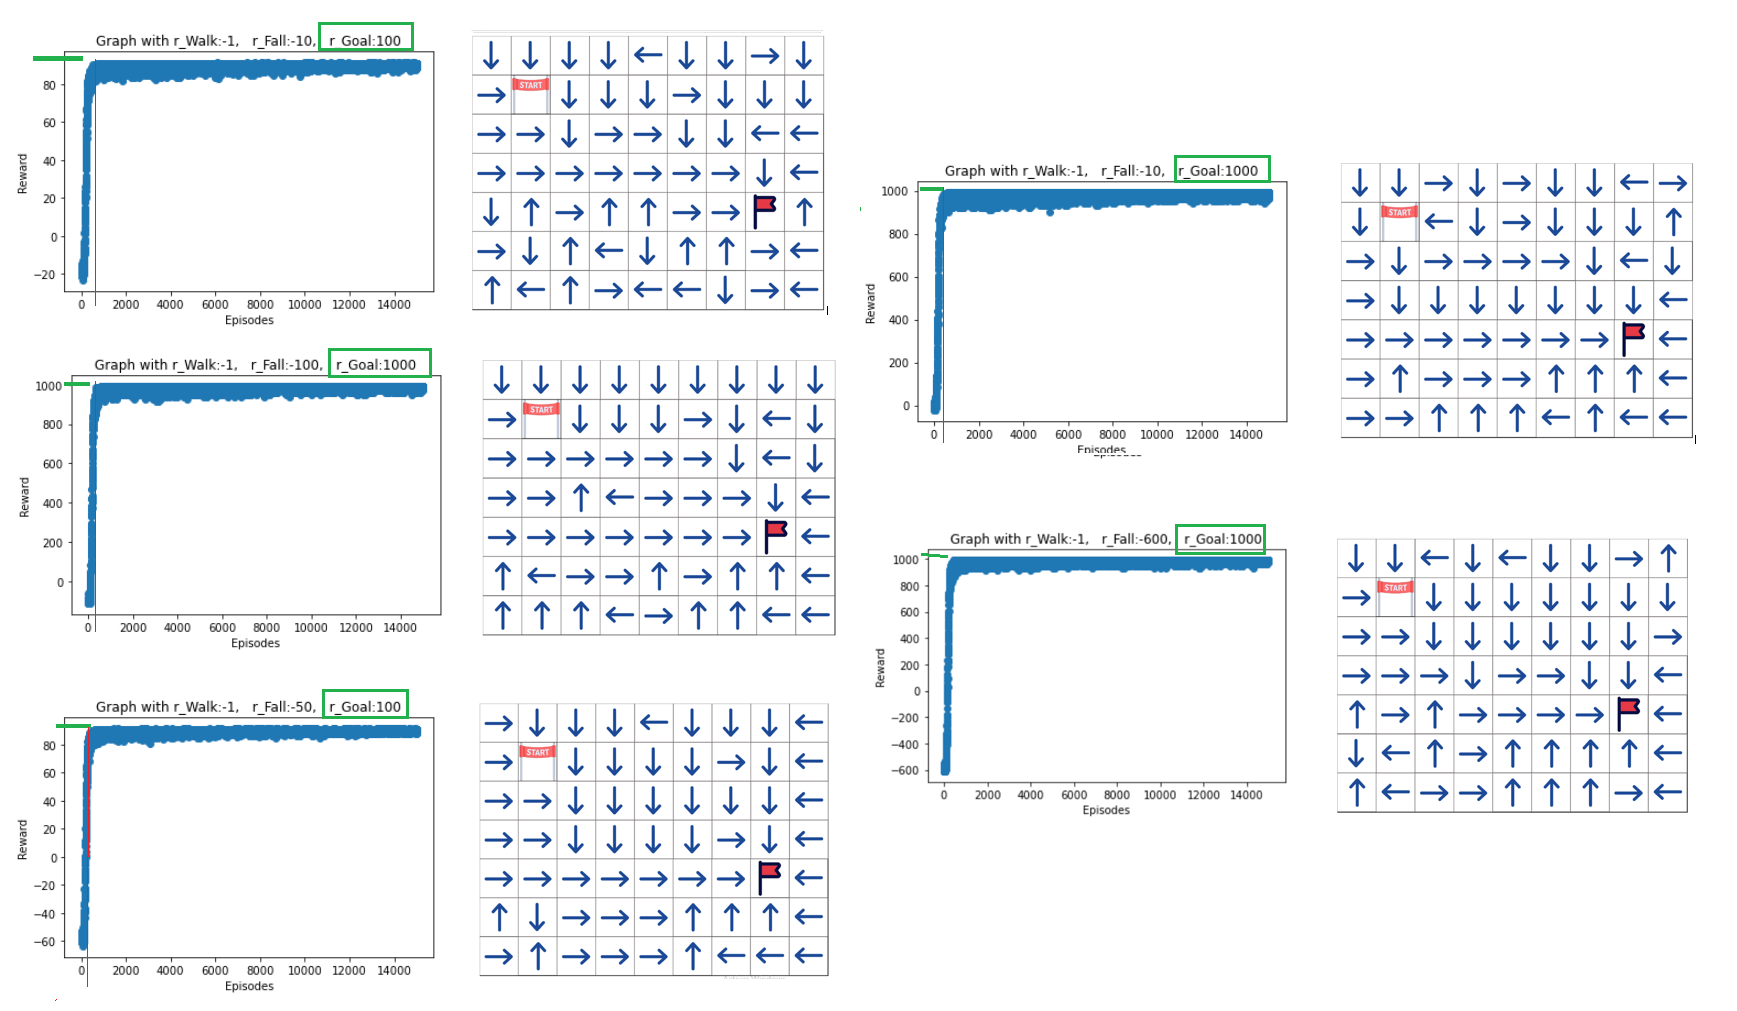

As can be seen, in the graphs of Episodes vs. Reward it can be verified that the algorithm is learning and manages to reach its maximum reward in less than 1000 episodes.

Datebox plots, on the other hand, represent the **policy** in q-table. In all the tests carried out, depending on the state (position in the grid) the *most* directions to take point to the destination point correctly. What demonstrates a correct learning on the part of the agent. Whose goal was to reach a goal from a starting point.

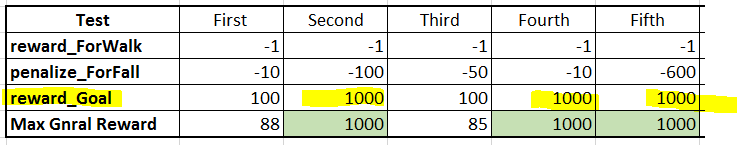

As for the parameters that were varied to carry out different tests, they were the assignment of reward and penalty.
As can be seen in the table, in this case the value that had the least effect was the penalty. On the other hand, if there were notable differences in terms of putting a high "reward_Goal". For example, when placing a value of 100, regardless of whether it was with a penalty of 10 or 50, in all the plays, on average, the highest reward I received was from 88 to 85. Instead, when defining a much higher reward as " 1000", on average of all the plays made, he successfully reached his corresponding maximum reward.

> Question 2: Find the optimal policy and plot the average reward over time

After the tests carried out, it was defined that the best optimal policy is the one that is trained with a very high "reward_Goal", since with this the maximum reward is obtained on average.

For this case, the **optimal policy** would be q_table_2 with a reward_Goal = 1000
The difference is little, but there is less variance in its average unlike q_table_4 which has the same value in its reward_Goal. And this is possibly because q_table_2 has a higher penalty than q_table_4, which makes the agent more cautious when selecting an action.

In [34]:
# optimal policy
q_table_2

array([[-7.17570464e+01, -3.14032740e+00, -7.94108868e+01,
         5.30367315e+01],
       [-8.33228183e+01,  5.57219929e+02, -3.19061227e+00,
         1.13498827e+01],
       [-7.17570464e+01,  6.01045918e+02, -2.74041892e+00,
        -2.77796537e+00],
       [-8.14697981e+01,  2.31766468e+01, -2.31014862e+00,
        -2.26435703e+00],
       [-6.86189404e+01, -1.83026226e+00, -1.86413646e+00,
        -1.83456411e+00],
       [-6.51321560e+01, -1.42214763e+00, -1.41805244e+00,
        -1.45885211e+00],
       [-1.00000000e+01, -1.31207092e+00, -1.23018644e+00,
        -5.69532790e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.18612019e+00, -3.40569352e+00, -9.28210201e+01,
         5.60894522e+02],
       [ 4.82589869e+02,  5.58110962e+02,  4.92956133e+02,
      

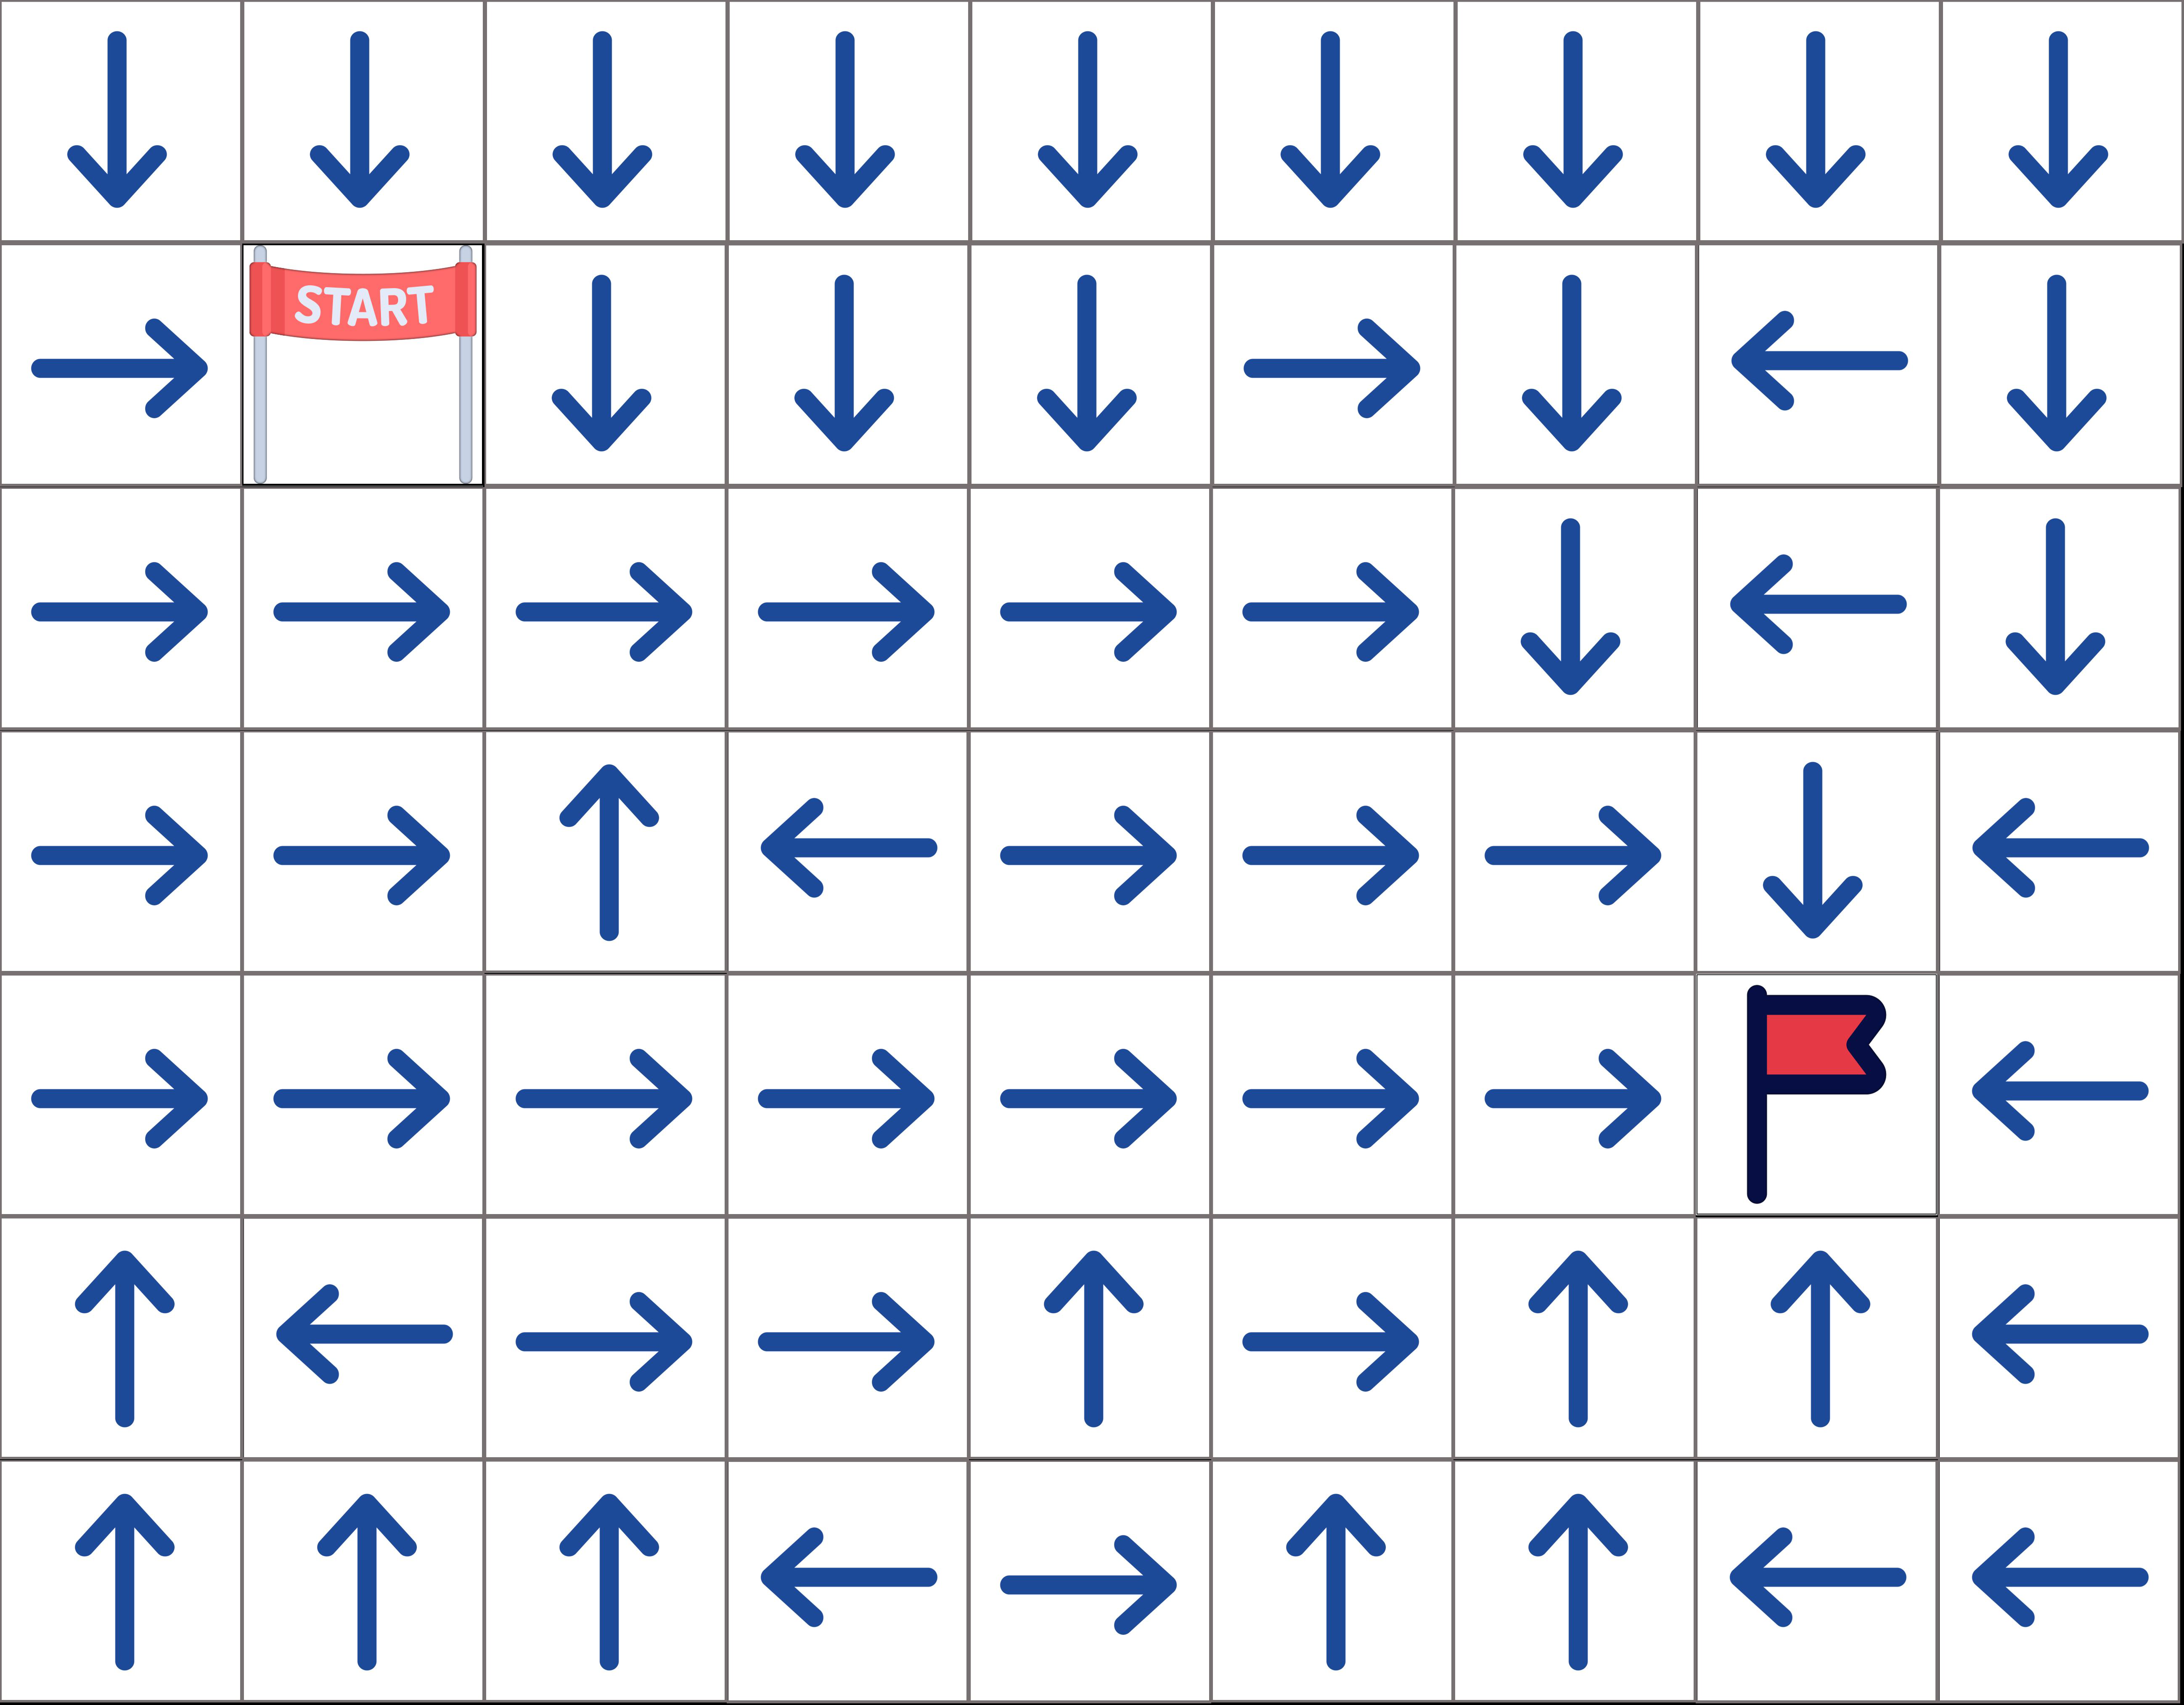

In [35]:
# graph of desicions of actions accoding optimal policy
display(get_imageOfPolicy(q_table_2))

As mentioned earlier, in this graph most of the action decisions are goal directed.

> Question 3: What happens if there are no winds? What does the optimal policy and the average reward over time look like? Comment your results

## Test without Wind

In [42]:
# Reset variables
rewards_avg = []

# Applying Q-learning
reward_ForWalk = -1
penalize_ForFall = -100
reward_Goal = 1000
envGame.setSpecificRewards(reward_ForWalk , penalize_ForFall, reward_Goal)
q_table_6 = train_Qtable(envGame,withWind = False )

average  0


C:\Users\INTER14\AppData\Local\Temp/ipykernel_8368/1331940733.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  map = np.zeros((size[1], size[0]), dtype=np.int)


average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
average  84
a

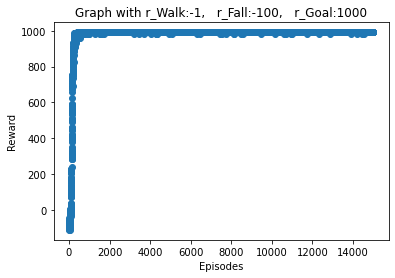

In [43]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.title(f"Graph with r_Walk:{reward_ForWalk},   r_Fall:{penalize_ForFall},   r_Goal:{reward_Goal}"  )
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

In [44]:
q_table_6

array([[-7.45813417e+01, -1.95550019e+00, -7.45813417e+01,
         8.47001319e+01],
       [-8.78423345e+01,  6.21071071e+02,  2.25513597e+00,
         7.47818191e+01],
       [-7.71232075e+01,  6.54626669e+02,  8.37081308e+01,
        -1.48297709e+00],
       [-5.69532790e+01,  1.15014952e+02, -1.03770011e+00,
        -3.84488741e-01],
       [-3.43900000e+01,  6.97746038e+01, -6.76861666e-01,
        -6.60845055e-01],
       [-2.71000000e+01, -3.04573000e-01, -4.19078492e-01,
        -3.63664750e-01],
       [-1.00000000e+01, -3.16248025e-01, -2.26180796e-01,
        -1.90000000e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.15690406e+00,  6.00524988e+02, -8.78423345e+01,
        -2.07740037e+00],
       [ 5.78557695e+02,  6.45388094e+02,  5.19030848e+02,
      

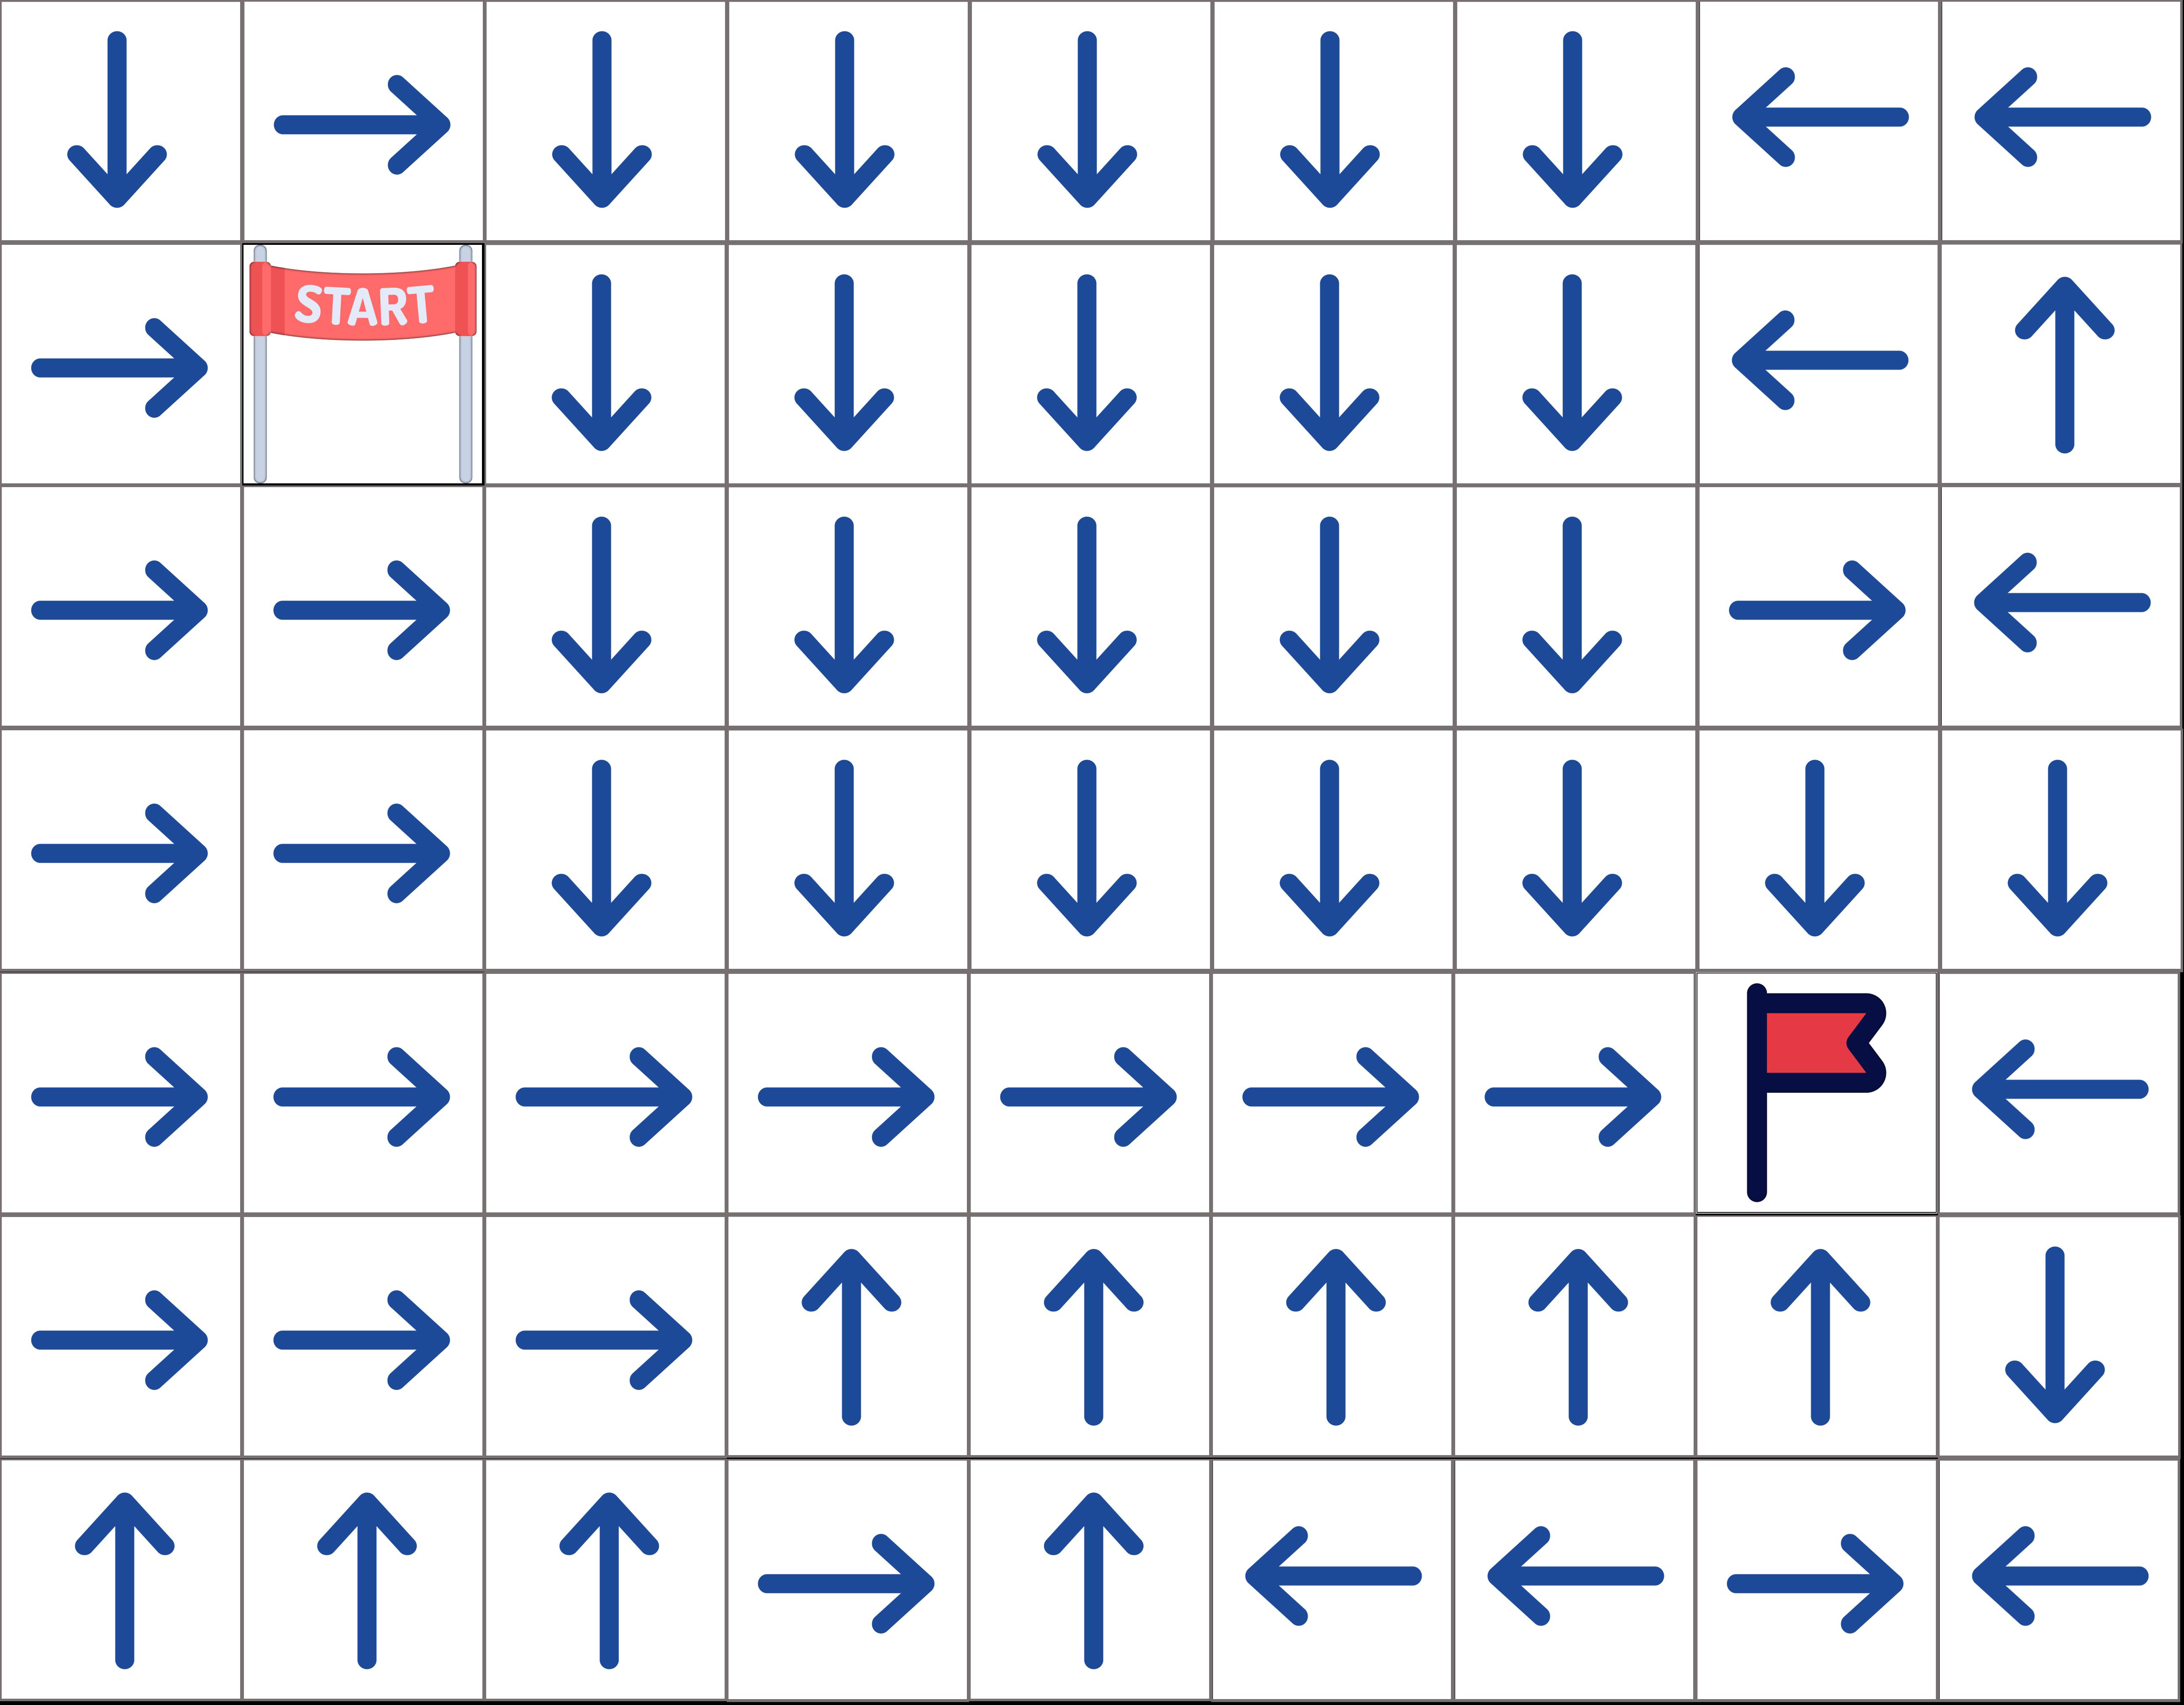

In [45]:
display(get_imageOfPolicy(q_table_6))

Thanks to the fact that the winds are avoided, it removes the difficulty for the agent to continue on his way to the goal. And as can be seen in the graph almost completely, the decisions about the actions to take go directly towards the goal.

## Conclusions

It was concluded that it is very important to analyze the values that may be in the reward and penalties to guide the agent